
## Conditional Autoencoder

In [ ]:
import tensorflow as tf                       # 텐서플로우 임포트
import tensorflow_probability as tfp

import matplotlib.pyplot as plt
from tensorflow.keras import models, layers   # 케라스 관련 모듈 임포트
import numpy as np

print("Tensorflow: ", tf.__version__)        # 텐서플로우 버전을 확인하도록 한다.
print("Keras: ", tf.keras.__version__)  # 케라스 버전을 확인한다.

print("Tensorflow Probability: ", tfp.__version__)       # TFP 버젼을 확인한다.


Tensorflow:  2.4.1
Keras:  2.4.0
Tensorflow Probability:  0.12.1


In [ ]:
# MNIST 데이터 로딩
mnist = tf.keras.datasets.mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

print('train_images의 *원래* 데이터의 shape과 dype:', 
      train_images.shape, train_images.dtype)
print('test_images의 *원래* 데이터의 shape과 dype:', 
      test_images.shape, test_images.dtype)

# Normalizing the images to the range of [0., 1.]
train_images = tf.cast(train_images, tf.float32)
test_images  = tf.cast(test_images, tf.float32)
train_images /= 255
test_images  /= 255

print('train_images의 *바뀐* 데이터의 shape과 dype:', 
      train_images.shape, train_images.dtype)
print('test_images의 *바뀐* 데이터의 shape과 dype:', 
      test_images.shape, test_images.dtype)


# Print out for checking
print(train_images[0].shape)
print(train_images[0][0][0].dtype)
print(train_labels.dtype)
print(train_labels[0].dtype)

11493376/11490434 [==============================] - 0s 0us/step
train_images의 *원래* 데이터의 shape과 dype: (60000, 28, 28) uint8
test_images의 *원래* 데이터의 shape과 dype: (10000, 28, 28) uint8
train_images의 *바뀐* 데이터의 shape과 dype: (60000, 28, 28) <dtype: 'float32'>
test_images의 *바뀐* 데이터의 shape과 dype: (10000, 28, 28) <dtype: 'float32'>
(28, 28)
<dtype: 'float32'>
uint8
uint8


In [ ]:
num_classes = 10

train_label_onehots = tf.keras.utils.to_categorical(train_labels, num_classes)
test_label_onehots  = tf.keras.utils.to_categorical(test_labels, num_classes)

# 데이터 변환 확인
print(train_label_onehots.shape)
print(test_label_onehots.shape)

print(train_label_onehots[0])
print(train_labels[0])
print(test_label_onehots[0])
print(test_labels[0])

(60000, 10)
(10000, 10)
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
5
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
7


## 모델 설계

In [ ]:
tfd = tfp.distributions

enc_dim = 2

prior = tfd.Independent(tfd.Normal(loc=tf.zeros(enc_dim), scale=1),
                        reinterpreted_batch_ndims=1)

In [ ]:
img = tf.keras.Input(shape = (28,28))
con = tf.keras.Input(shape = (10,))

enc_flat = tf.keras.layers.Flatten()
enc_dense1 = tf.keras.layers.Dense(256, activation = 'relu')
enc_dense2 = tf.keras.layers.Dense(128, activation='relu')
enc_dense3 = tf.keras.layers.Dense(64, activation= 'relu')
enc_dense4 = tf.keras.layers.Dense(32, activation='relu')
enc_dense5 = tf.keras.layers.Dense(4)
enc_proba = tfp.layers.IndependentNormal(enc_dim ,
                                         activity_regularizer = tfp.layers.KLDivergenceRegularizer(prior, weight = 1e-4))

x = enc_flat(img)
x = tf.keras.layers.concatenate([x, con])
x = enc_dense1(x)
x = enc_dense2(x)
x = enc_dense3(x)
x = enc_dense4(x)
x = enc_dense5(x)
z = enc_proba(x)

c_vae_encoder = tf.keras.Model(inputs = [img,con], outputs= z, name = 'encoder')

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_20 (InputLayer)           [(None, 28, 28)]     0                                            
__________________________________________________________________________________________________
flatten_9 (Flatten)             (None, 784)          0           input_20[0][0]                   
__________________________________________________________________________________________________
input_21 (InputLayer)           [(None, 10)]         0                                            
__________________________________________________________________________________________________
concatenate_11 (Concatenate)    (None, 794)          0           flatten_9[0][0]                  
                                                                 input_21[0][0]             

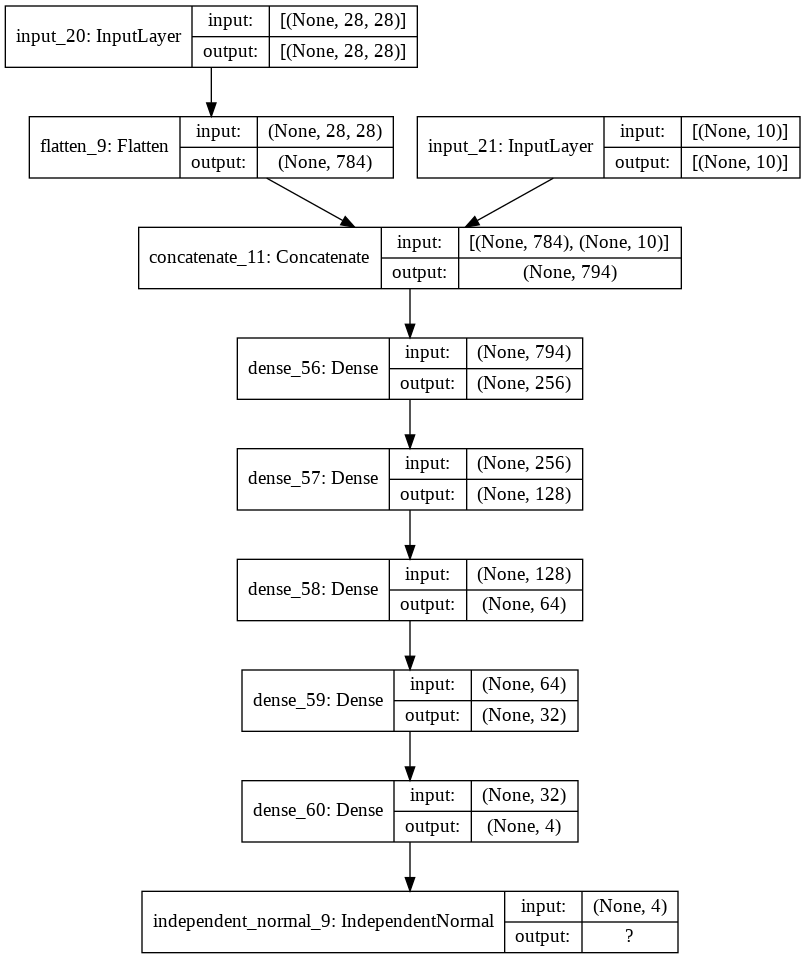

In [ ]:
c_vae_encoder.summary()
tf.keras.utils.plot_model(c_vae_encoder, show_shapes=True)

In [ ]:
dec_z = tf.keras.layers.Input(shape = (enc_dim,))
dec_dense_1 = tf.keras.layers.Dense(64, activation='relu')
dec_dense_2 = tf.keras.layers.Dense(128, activation='relu')
dec_dense_3 = tf.keras.layers.Dense(256, activation='relu')
dec_dense_4 = tf.keras.layers.Dense(28*28, activation='sigmoid')
dec_reshape = tf.keras.layers.Reshape(target_shape=(28,28))


x = tf.keras.layers.concatenate([dec_z, con])
x = dec_dense_1(x)
x = dec_dense_2(x)
x = dec_dense_3(x)
x = dec_dense_4(x)
y_pred = dec_reshape(x)

c_vae_decoder = tf.keras.Model(inputs = [dec_z, con], outputs = y_pred, name = 'decoder')

Model: "decoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 2)]          0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           [(None, 10)]         0                                            
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 12)           0           input_13[0][0]                   
                                                                 input_12[0][0]                   
__________________________________________________________________________________________________
dense_37 (Dense)                (None, 64)           832         concatenate_7[0][0]        

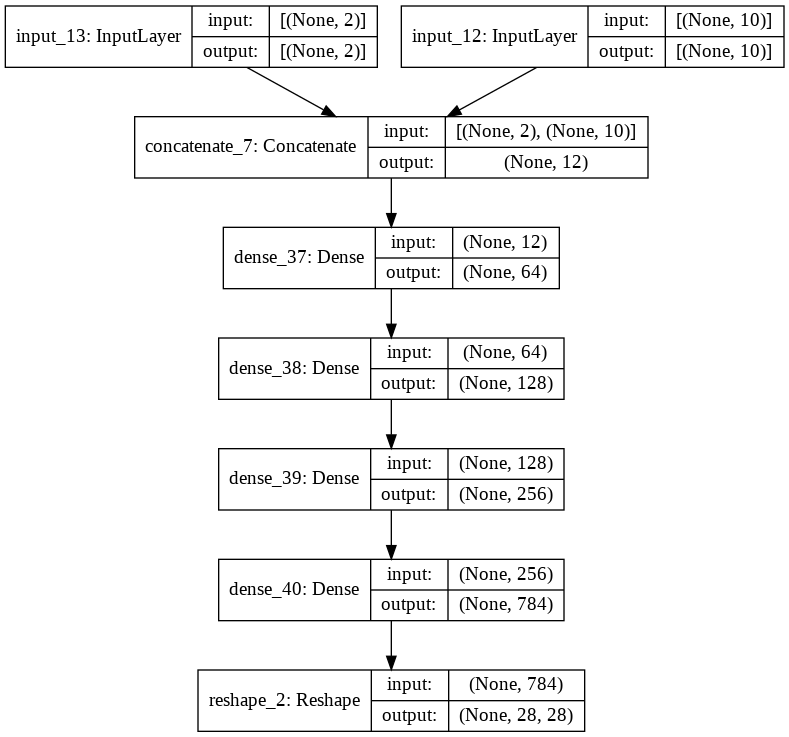

In [ ]:
c_vae_decoder.summary()
tf.keras.utils.plot_model(c_vae_decoder, show_shapes=True)

In [ ]:
encoder_out = c_vae_encoder([img,con])
decoder_out = c_vae_decoder([encoder_out,con])
c_vae = tf.keras.Model([img,con], decoder_out , name = 'Conditional_VAE')

In [ ]:
# VAE 모델 컴파일 (* loss 함수가 중요!)

c_vae.compile(optimizer='adam',            
            #loss=tf.keras.losses.BinaryCrossentropy(reduction=tf.losses.Reduction.SUM),
            loss=tf.keras.losses.BinaryCrossentropy(),
            metrics=['mae'])

Model: "Conditional_VAE"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_20 (InputLayer)           [(None, 28, 28)]     0                                            
__________________________________________________________________________________________________
input_21 (InputLayer)           [(None, 10)]         0                                            
__________________________________________________________________________________________________
encoder (Functional)            multiple             246884      input_20[0][0]                   
                                                                 input_21[0][0]                   
__________________________________________________________________________________________________
decoder (Functional)            (None, 28, 28)       243664      encoder[1][0]      

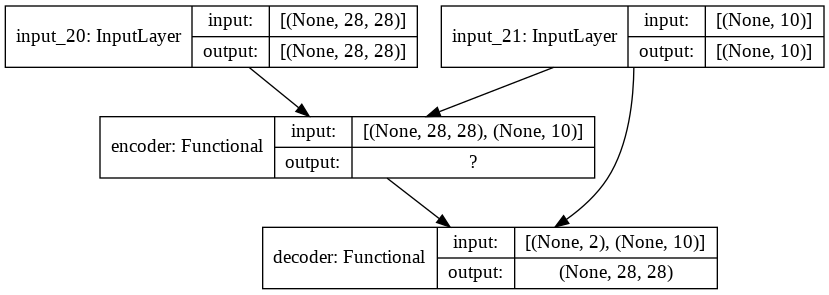

In [ ]:
c_vae.summary()
tf.keras.utils.plot_model(c_vae, show_shapes=True)

## 훈련 전, 네트워크 모델을 함수로서 활용

In [ ]:
y_pred = c_vae([train_images,train_label_onehots])
print('input shape:', train_images.shape)
print('condition shape:', train_label_onehots.shape)
print('output shape:', y_pred.shape)

input shape: (60000, 28, 28)
condition shape: (60000, 10)
output shape: (60000, 28, 28)


In [ ]:
import ipywidgets as widgets

def io_imshow(idx):
  print('GT label:', train_labels[idx])
  plt.subplot(121)
  plt.imshow(train_images[idx])
  plt.subplot(122)
  plt.imshow(y_pred[idx])
  plt.show()

widgets.interact(io_imshow, idx=widgets.IntSlider(min=0, max=train_images.shape[0]-1, continuous_update=False));

interactive(children=(IntSlider(value=0, continuous_update=False, description='idx', max=59999), Output()), _d…

In [ ]:
z = c_vae_encoder([train_images,train_label_onehots])
y = c_vae_decoder([z.sample(), train_label_onehots])

print(z.shape)
print(y.shape)

(60000, 2)
(60000, 28, 28)


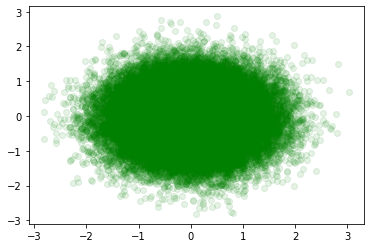

In [ ]:
import matplotlib.pyplot as plt

plt.plot(z[:,0], z[:,1], "go", alpha=0.1)
plt.show()

## VAE 인스턴스 트레이닝

In [ ]:
epochs = 20
batch_size = 100

c_vae.fit([train_images,train_label_onehots], train_images, epochs=epochs, batch_size=batch_size)

Epoch 1/20
600/600 [==============================] - 3s 3ms/step - loss: 0.2749 - mae: 0.1593
Epoch 2/20
600/600 [==============================] - 2s 3ms/step - loss: 0.1764 - mae: 0.0916
Epoch 3/20
600/600 [==============================] - 2s 3ms/step - loss: 0.1690 - mae: 0.0863
Epoch 4/20
600/600 [==============================] - 2s 3ms/step - loss: 0.1664 - mae: 0.0843
Epoch 5/20
600/600 [==============================] - 2s 3ms/step - loss: 0.1648 - mae: 0.0831
Epoch 6/20
600/600 [==============================] - 2s 3ms/step - loss: 0.1638 - mae: 0.0823
Epoch 7/20
600/600 [==============================] - 2s 3ms/step - loss: 0.1629 - mae: 0.0817
Epoch 8/20
600/600 [==============================] - 2s 3ms/step - loss: 0.1621 - mae: 0.0811
Epoch 9/20
600/600 [==============================] - 2s 3ms/step - loss: 0.1622 - mae: 0.0811
Epoch 10/20
600/600 [==============================] - 2s 3ms/step - loss: 0.1614 - mae: 0.0805
Epoch 11/20
600/600 [============================

## 트레이닝이 끝난 VAE를 이용하기

In [ ]:
y_pred = c_vae([train_images,train_label_onehots])

In [ ]:
import ipywidgets as widgets

def io_imshow(idx):
  print('GT label:', train_labels[idx])
  plt.subplot(121)
  plt.imshow(train_images[idx])
  plt.subplot(122)
  plt.imshow(y_pred[idx])
  plt.show()

widgets.interact(io_imshow, idx=widgets.IntSlider(min=0, max=train_images.shape[0]-1, continuous_update=False));

interactive(children=(IntSlider(value=0, continuous_update=False, description='idx', max=59999), Output()), _d…

In [ ]:
## test set에 대한 결과 

y_pred_test = c_vae([test_images,test_label_onehots])

In [ ]:
import ipywidgets as widgets

def io_imshow(idx):
  print('GT label:', test_labels[idx])
  plt.subplot(121)
  plt.imshow(test_images[idx])
  plt.subplot(122)
  plt.imshow(y_pred_test[idx])
  plt.show()

widgets.interact(io_imshow, idx=widgets.IntSlider(min=0, max=test_images.shape[0]-1, continuous_update=False));

interactive(children=(IntSlider(value=0, continuous_update=False, description='idx', max=9999), Output()), _do…

- conditional vae의 결과를 확인해 보면 기존 이미지가 이상함에도, 결과를 잘 나타냄을 확인할 수 있다. condition을 같이 주기 때문에 그런거 같다.

- 또한 test set에 대해서도 이미지 생성을 잘 하는것을 확인할 수 있다.

In [ ]:
z = c_vae_encoder([train_images,train_label_onehots])
y = c_vae_decoder([z.sample(),train_label_onehots])

print(z.shape)
print(y.shape)

(60000, 2)
(60000, 28, 28)


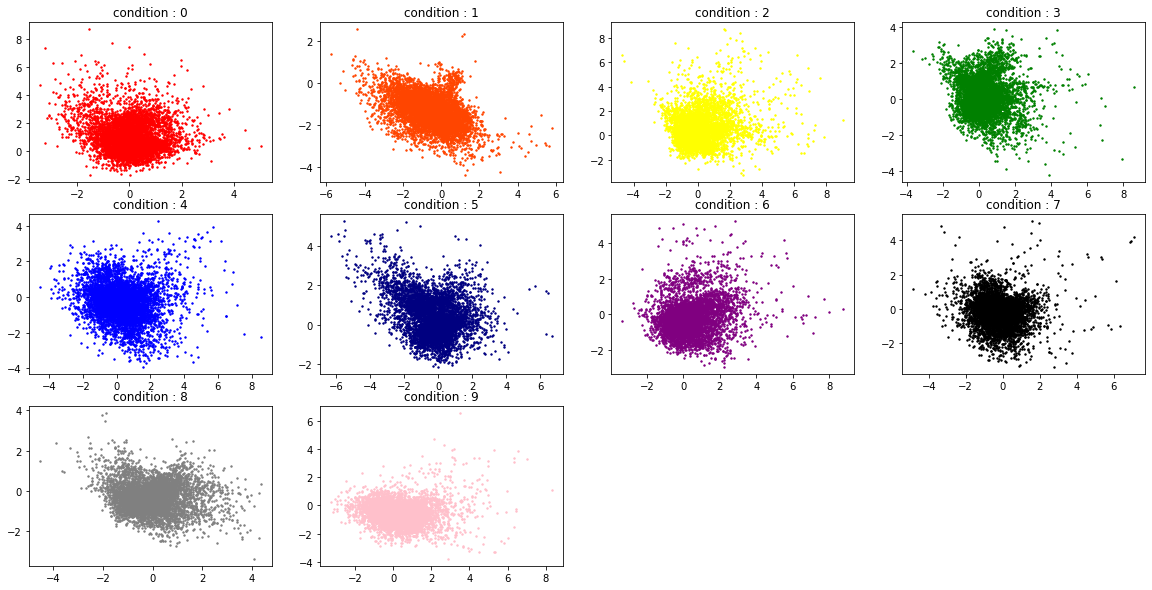

In [ ]:
z_0 = z[train_labels==0]    # z 배열을 조건을 이용해 slice
z_1 = z[train_labels==1]
z_2 = z[train_labels==2]
z_3 = z[train_labels==3]
z_4 = z[train_labels==4]
z_5 = z[train_labels==5]
z_6 = z[train_labels==6]
z_7 = z[train_labels==7]
z_8 = z[train_labels==8]
z_9 = z[train_labels==9]

plt.figure(figsize=(20,10))
plt.tight_layout()

plt.subplot(341)
plt.title('condition : 0')
plt.scatter(z_0[:,0], z_0[:,1], c = 'r', s =2)
plt.subplot(342)
plt.title('condition : 1')
plt.scatter(z_1[:,0], z_1[:,1], c = 'orangered',s =2)
plt.subplot(343)
plt.title('condition : 2')
plt.scatter(z_2[:,0], z_2[:,1], c = 'yellow',s =2)
plt.subplot(344)
plt.title('condition : 3')
plt.scatter(z_3[:,0], z_3[:,1], c = 'green',s =2)
plt.subplot(345)
plt.title('condition : 4')
plt.scatter(z_4[:,0], z_4[:,1], c = 'b',s =2)
plt.subplot(346)
plt.title('condition : 5')
plt.scatter(z_5[:,0], z_5[:,1], c = 'navy',s =2)
plt.subplot(347)
plt.title('condition : 6')
plt.scatter(z_6[:,0], z_6[:,1], c = 'purple',s =2)
plt.subplot(348)
plt.title('condition : 7')
plt.scatter(z_7[:,0], z_7[:,1], c = 'black',s =2)
plt.subplot(349)
plt.title('condition : 8')
plt.scatter(z_8[:,0], z_8[:,1], c = 'gray',s =2)
plt.subplot(3,4,10)
plt.title('condition : 9')
plt.scatter(z_9[:,0], z_9[:,1], c = 'pink',s =2)

plt.show()

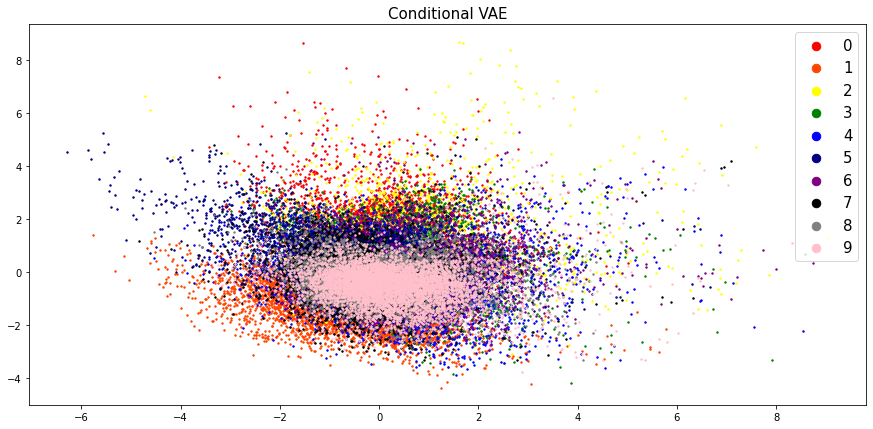

In [ ]:
plt.figure(figsize=(15,7))
plt.title('Conditional VAE', fontsize = 15)

plt.scatter(z_0[:,0], z_0[:,1], c = 'r', s =2)
plt.scatter(z_1[:,0], z_1[:,1], c = 'orangered',s =2)
plt.scatter(z_2[:,0], z_2[:,1], c = 'yellow',s =2)
plt.scatter(z_3[:,0], z_3[:,1], c = 'green',s =2)
plt.scatter(z_4[:,0], z_4[:,1], c = 'b',s =2)
plt.scatter(z_5[:,0], z_5[:,1], c = 'navy',s =2)
plt.scatter(z_6[:,0], z_6[:,1], c = 'purple',s =2)
plt.scatter(z_7[:,0], z_7[:,1], c = 'black',s =2)
plt.scatter(z_8[:,0], z_8[:,1], c = 'gray',s =2)
plt.scatter(z_9[:,0], z_9[:,1], c = 'pink',s =2)

plt.legend([0,1,2,3,4,5,6,7,8,9], fontsize = 15, markerscale=6)
plt.show()

- 각 condition 별로 latent vector의 scatter plot을 확인해보면, 전체적으로는 0과 가까이 붙어 있어 정규분포를 따른다고 볼 수 있지만 명확한 결과를 비교하기 위해 데이터의 histogram을 확인해보도록 하겠다.

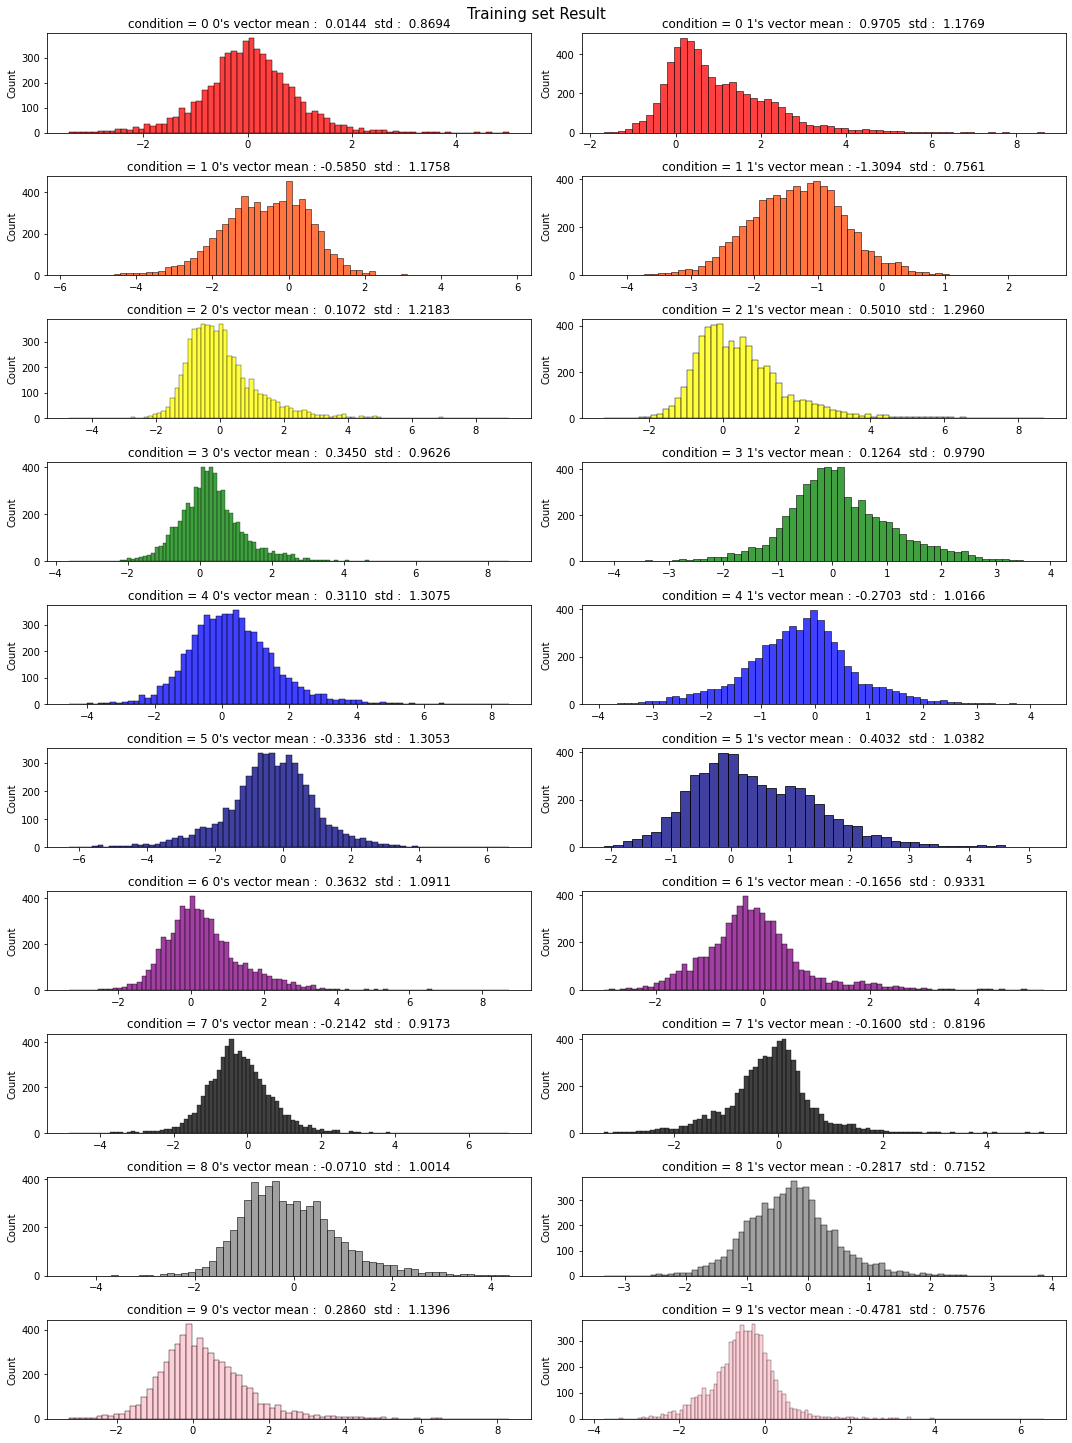

In [ ]:
import seaborn as sns

z_list = [z_0,z_1,z_2,z_3,z_4,z_5,z_6,z_7,z_8,z_9]
color_list = ['r', 'orangered', 'yellow', 'green', 'b', 'navy', 'purple', 'black', 'gray', 'pink']
f, axes = plt.subplots(10,2 , figsize = (15,20))
axes = axes.flatten()

j = 0
for i in range(0,10) :
  mean = np.mean(z_list[i][:,0])
  std = np.std(z_list[i][:,0])
  sns.histplot(z_list[i][:,0] ,ax = axes[j], color= color_list[i])
  axes[j].set_title(f"condition = {i} 0's vector mean : {mean : .4f}  std : {std : .4f}")
  j += 1
  
  mean = np.mean(z_list[i][:,1])
  std = np.std(z_list[i][:,1])
  sns.histplot(z_list[i][:,1] ,ax = axes[j], color = color_list[i])
  axes[j].set_title(f"condition = {i} 1's vector mean : {mean : .4f}  std : {std : .4f}")
  j += 1

plt.suptitle('Training set Result', y = 1, fontsize = 15)
plt.tight_layout()
plt.show()

- 결과를 확인해보면 , condition = 0, 1의 두번째 차원의 latent vector에 대해서를 제외하고는 대부분 평균이 0에 근사하고 std 가 1인 분포를 띄는것을 확인할 수 있다.

### Test set 에 대해서 확인

In [ ]:
z_test = c_vae_encoder([test_images,test_label_onehots])
y_test = c_vae_decoder([z_test.sample(),test_label_onehots])

print(z_test.shape)
print(y_test.shape)

(10000, 2)
(10000, 28, 28)


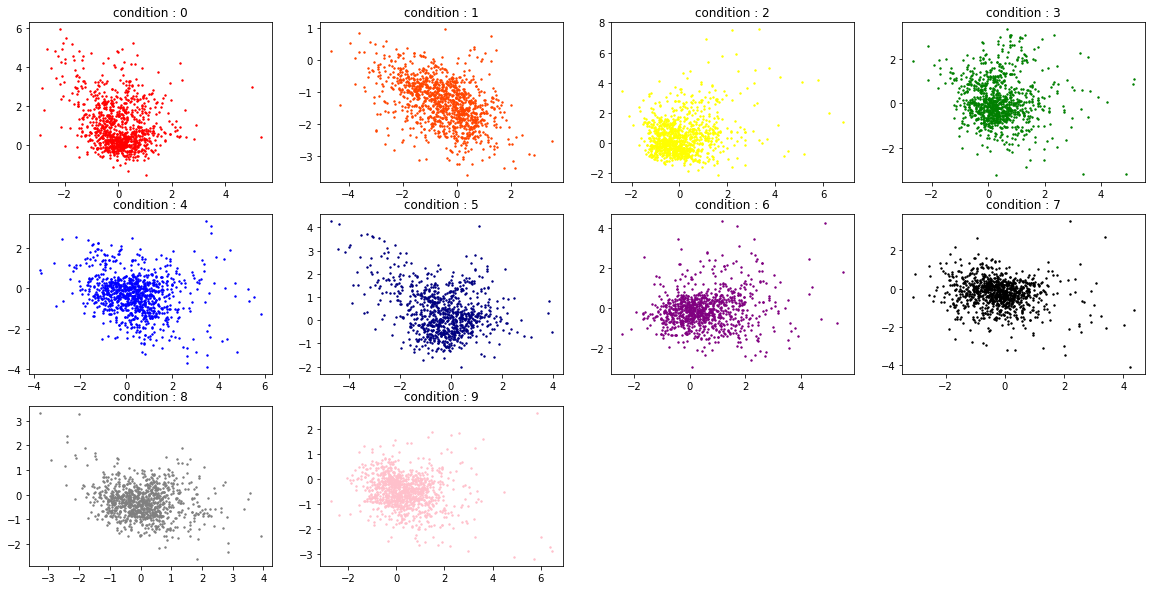

In [ ]:
z_0 = z_test[test_labels==0]    # z 배열을 조건을 이용해 slice
z_1 = z_test[test_labels==1]
z_2 = z_test[test_labels==2]
z_3 = z_test[test_labels==3]
z_4 = z_test[test_labels==4]
z_5 = z_test[test_labels==5]
z_6 = z_test[test_labels==6]
z_7 = z_test[test_labels==7]
z_8 = z_test[test_labels==8]
z_9 = z_test[test_labels==9]

plt.figure(figsize=(20,10))
plt.tight_layout()

plt.subplot(341)
plt.title('condition : 0')
plt.scatter(z_0[:,0], z_0[:,1], c = 'r', s =2)
plt.subplot(342)
plt.title('condition : 1')
plt.scatter(z_1[:,0], z_1[:,1], c = 'orangered',s =2)
plt.subplot(343)
plt.title('condition : 2')
plt.scatter(z_2[:,0], z_2[:,1], c = 'yellow',s =2)
plt.subplot(344)
plt.title('condition : 3')
plt.scatter(z_3[:,0], z_3[:,1], c = 'green',s =2)
plt.subplot(345)
plt.title('condition : 4')
plt.scatter(z_4[:,0], z_4[:,1], c = 'b',s =2)
plt.subplot(346)
plt.title('condition : 5')
plt.scatter(z_5[:,0], z_5[:,1], c = 'navy',s =2)
plt.subplot(347)
plt.title('condition : 6')
plt.scatter(z_6[:,0], z_6[:,1], c = 'purple',s =2)
plt.subplot(348)
plt.title('condition : 7')
plt.scatter(z_7[:,0], z_7[:,1], c = 'black',s =2)
plt.subplot(349)
plt.title('condition : 8')
plt.scatter(z_8[:,0], z_8[:,1], c = 'gray',s =2)
plt.subplot(3,4,10)
plt.title('condition : 9')
plt.scatter(z_9[:,0], z_9[:,1], c = 'pink',s =2)

plt.show()

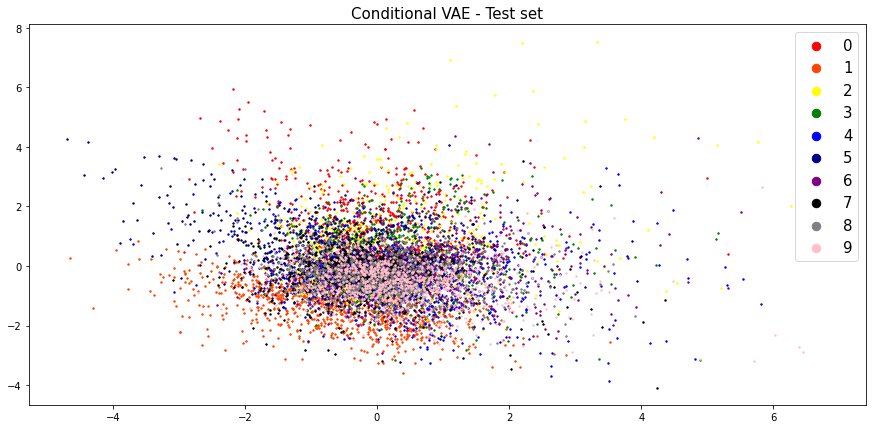

In [ ]:
plt.figure(figsize=(15,7))
plt.title('Conditional VAE - Test set', fontsize = 15)

plt.scatter(z_0[:,0], z_0[:,1], c = 'r', s =2)
plt.scatter(z_1[:,0], z_1[:,1], c = 'orangered',s =2)
plt.scatter(z_2[:,0], z_2[:,1], c = 'yellow',s =2)
plt.scatter(z_3[:,0], z_3[:,1], c = 'green',s =2)
plt.scatter(z_4[:,0], z_4[:,1], c = 'b',s =2)
plt.scatter(z_5[:,0], z_5[:,1], c = 'navy',s =2)
plt.scatter(z_6[:,0], z_6[:,1], c = 'purple',s =2)
plt.scatter(z_7[:,0], z_7[:,1], c = 'black',s =2)
plt.scatter(z_8[:,0], z_8[:,1], c = 'gray',s =2)
plt.scatter(z_9[:,0], z_9[:,1], c = 'pink',s =2)

plt.legend([0,1,2,3,4,5,6,7,8,9], fontsize = 15, markerscale=6)
plt.show()

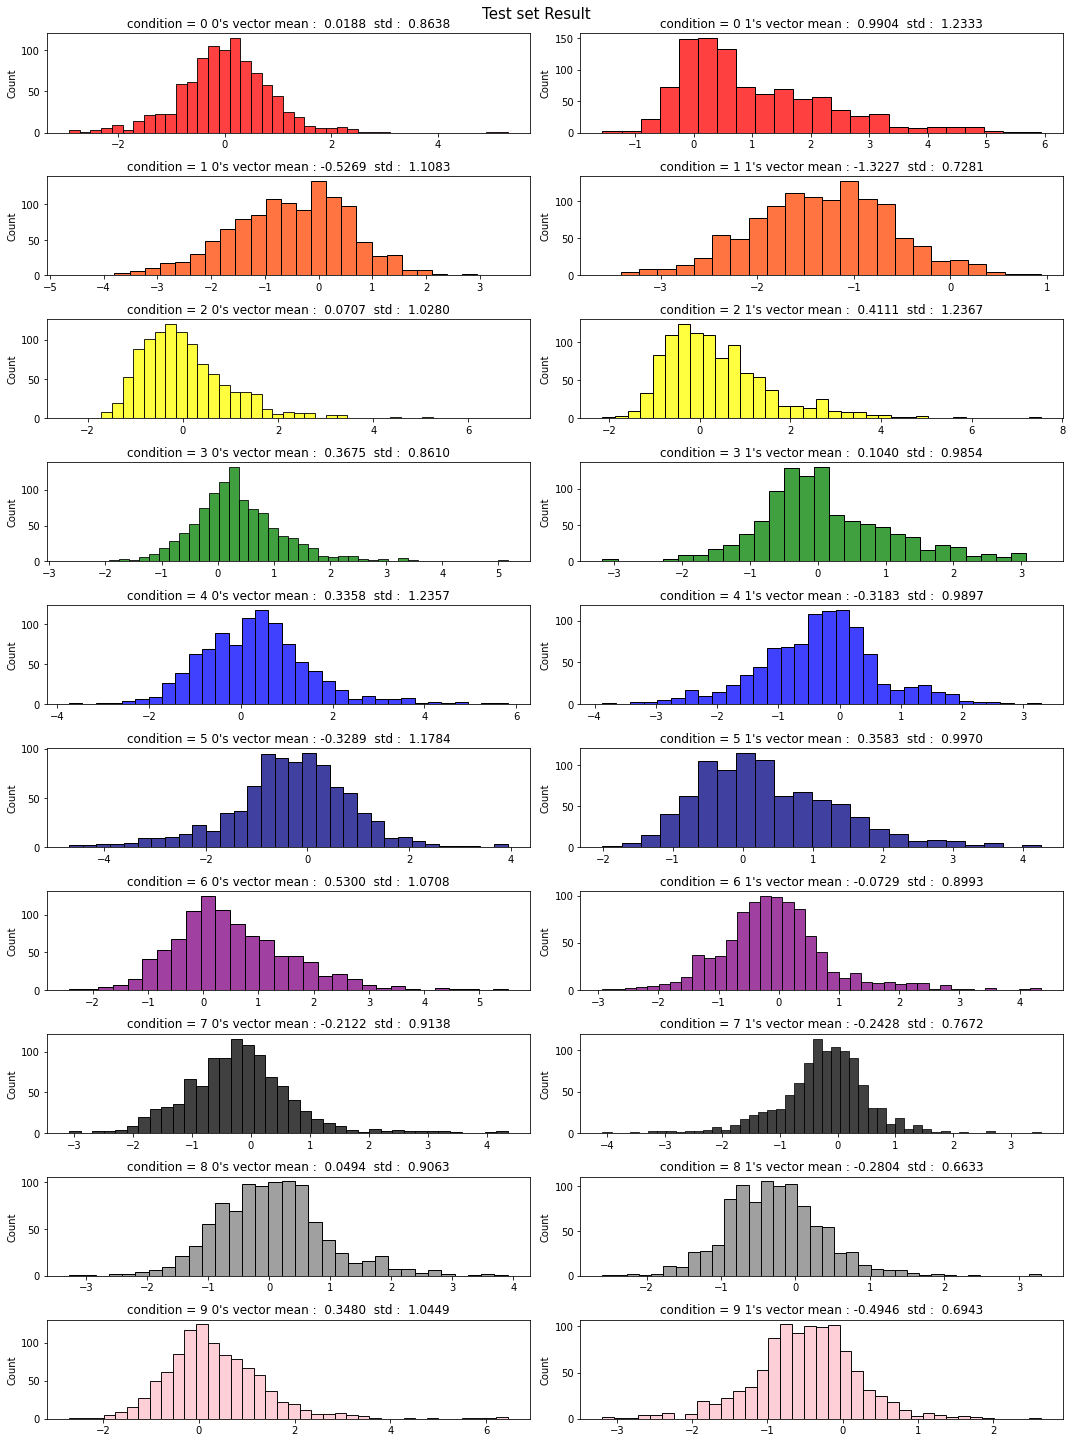

In [ ]:
z_list = [z_0,z_1,z_2,z_3,z_4,z_5,z_6,z_7,z_8,z_9]
color_list = ['r', 'orangered', 'yellow', 'green', 'b', 'navy', 'purple', 'black', 'gray', 'pink']
f, axes = plt.subplots(10,2 , figsize = (15,20))
axes = axes.flatten()

j = 0
for i in range(0,10) :
  mean = np.mean(z_list[i][:,0])
  std = np.std(z_list[i][:,0])
  sns.histplot(z_list[i][:,0] ,ax = axes[j], color= color_list[i])
  axes[j].set_title(f"condition = {i} 0's vector mean : {mean : .4f}  std : {std : .4f}")
  j += 1
  
  mean = np.mean(z_list[i][:,1])
  std = np.std(z_list[i][:,1])
  sns.histplot(z_list[i][:,1] ,ax = axes[j], color = color_list[i])
  axes[j].set_title(f"condition = {i} 1's vector mean : {mean : .4f}  std : {std : .4f}")
  j += 1

plt.suptitle('Test set Result', y = 1, fontsize = 15)
plt.tight_layout()
plt.show()

- Test set에 대해서 결과를 확인해 보면,위와 마찬가지로 condition = 0, 1인 latent vector의  두번째 차원을 제외하고, 대부분의 condition에 대하여 latent vector들의 분포가 기존에 정의한 평균이 0이고 , 표준편차가 1인 정규분포를 보임을 확인할 수 있다 .

- 1 : $q(z|x)$ 에서 뽑인 z값에 대한 이미지 생성 결과  

In [ ]:
def z_show(idx):
  print(z[idx])
  print('GT label:', train_labels[idx])

widgets.interact(z_show, idx=widgets.IntSlider(min=0, max=train_images.shape[0]-1));

interactive(children=(IntSlider(value=0, description='idx', max=59999), Output()), _dom_classes=('widget-inter…

In [ ]:
## 디코더의 테스트 입력 설정

import ipywidgets as widgets

u=widgets.FloatSlider(min=-5.0, max=5.0)
v=widgets.FloatSlider(min=-5.0, max=5.0)

ui = widgets.HBox([u,v])

def z_test(u, v):
  z_test = np.array([[u,v]])  
  c_test = np.array([[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]) # ground truth : 1 라는 condition을 부여
  print(z_test)

  img_gen = c_vae_decoder([z_test, c_test])
  plt.imshow(img_gen[0])
  plt.show()  

out = widgets.interactive_output(z_test, {'u': u, 'v': v})

display(ui, out)

Output()

- q(z|x)에서 idx = 14224에 대하여 뽑힌 z 값 (0.613, -1.59) GT : 1을 decoder의 input으로 넣었을 경우 output을 시각화 해보면, 이미지를 상당히 잘 만들어 내는 것을 확인할 수 있다.

- 2 : $p(z)$  : 위에서 정의된 prior에 대하여  sampling한 z에 대한 결과

In [ ]:
prior_sample = prior.sample(sample_shape=(10))
prior_sample

<tf.Tensor: shape=(10, 2), dtype=float32, numpy=
array([[-0.8226202 , -0.71626616],
       [ 1.0676905 , -1.2442605 ],
       [-1.694294  ,  0.11303528],
       [ 0.98745066,  0.8195499 ],
       [ 1.8406698 , -0.14406964],
       [ 0.5280279 , -1.0436376 ],
       [-1.6343063 ,  0.6886913 ],
       [-0.08781247,  1.5015235 ],
       [ 0.8874032 , -0.9641489 ],
       [-0.54124904, -0.5070011 ]], dtype=float32)>

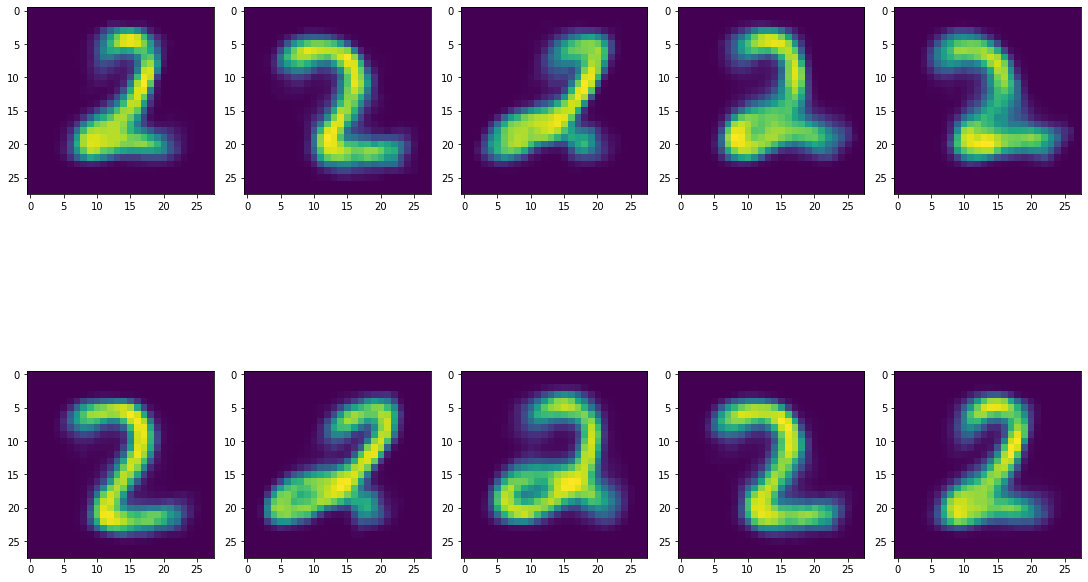

In [ ]:
f, axes = plt.subplots(2,5 , figsize = (15,10), constrained_layout=True)
axes = axes.flatten()

for i in range(len(prior_sample)) :
  z_sample = np.array([prior_sample[i]])
  condition_sample = np.array([[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]) # GT = 2 로 condition 부여 
  img_gen = c_vae_decoder([z_sample, condition_sample])
  axes[i].imshow(img_gen[0])
plt.show()

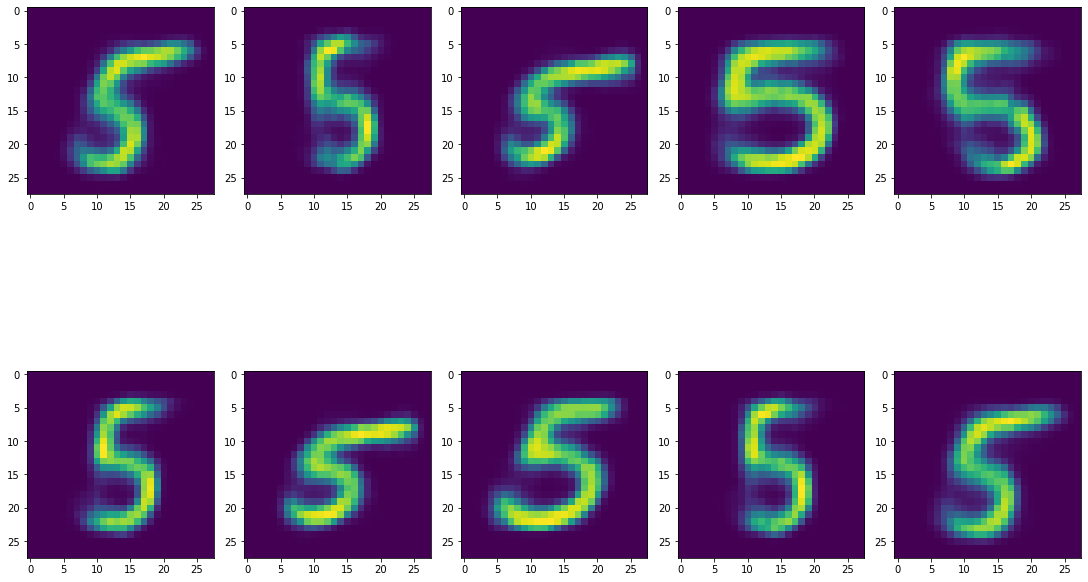

In [ ]:
f, axes = plt.subplots(2,5 , figsize = (15,10), constrained_layout=True)
axes = axes.flatten()

for i in range(len(prior_sample)) :
  z_sample = np.array([prior_sample[i]])
  condition_sample = np.array([[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]]) # GT = 5 로 condition 부여 
  img_gen = c_vae_decoder([z_sample, condition_sample])
  axes[i].imshow(img_gen[0])
plt.show()

- 결과를 확인해 보면 , prior 분포인 p(z)에서  sampling한 z값에 대해서도 condition을 결합하면 이미지 생성을 잘 해냄을 확인할 수 있다.

In [ ]:
tfd = tfp.distributions

enc_dim = 3

prior = tfd.Independent(tfd.Normal(loc=tf.zeros(enc_dim), scale=1),
                        reinterpreted_batch_ndims=1)

In [ ]:
img = tf.keras.Input(shape = (28,28))
con = tf.keras.Input(shape = (10,))

enc_flat = tf.keras.layers.Flatten()
enc_dense1 = tf.keras.layers.Dense(256, activation = 'relu')
enc_dense2 = tf.keras.layers.Dense(128, activation='relu')
enc_dense3 = tf.keras.layers.Dense(64, activation= 'relu')
enc_dense4 = tf.keras.layers.Dense(32, activation='relu')
enc_dense5 = tf.keras.layers.Dense(enc_dim * 2 )
enc_proba = tfp.layers.IndependentNormal(enc_dim ,
                                         activity_regularizer = tfp.layers.KLDivergenceRegularizer(prior, weight = 1e-4))

x = enc_flat(img)
x = tf.keras.layers.concatenate([x, con])
x = enc_dense1(x)
x = enc_dense2(x)
x = enc_dense3(x)
x = enc_dense4(x)
x = enc_dense5(x)
z = enc_proba(x)

c_vae_encoder_3 = tf.keras.Model(inputs = [img,con], outputs= z, name = 'encoder')

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_23 (InputLayer)           [(None, 28, 28)]     0                                            
__________________________________________________________________________________________________
flatten_10 (Flatten)            (None, 784)          0           input_23[0][0]                   
__________________________________________________________________________________________________
input_24 (InputLayer)           [(None, 10)]         0                                            
__________________________________________________________________________________________________
concatenate_13 (Concatenate)    (None, 794)          0           flatten_10[0][0]                 
                                                                 input_24[0][0]             

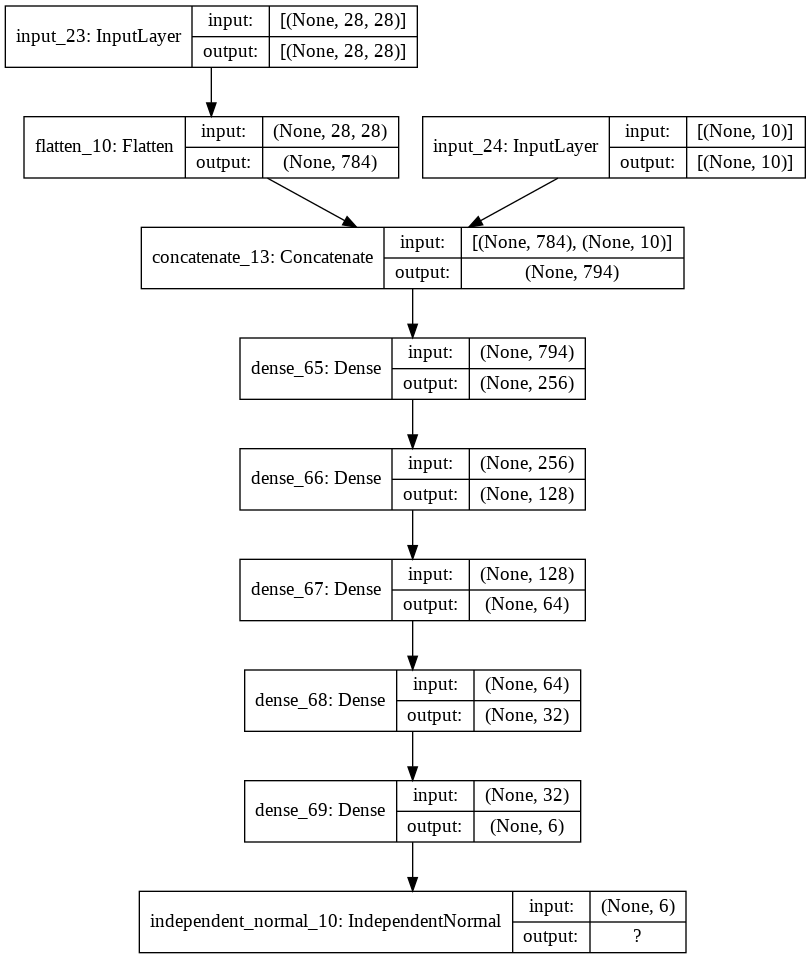

In [ ]:
c_vae_encoder_3.summary()
tf.keras.utils.plot_model(c_vae_encoder_3, show_shapes=True)

In [ ]:
dec_z = tf.keras.layers.Input(shape = (enc_dim,))
dec_dense_1 = tf.keras.layers.Dense(64, activation='relu')
dec_dense_2 = tf.keras.layers.Dense(128, activation='relu')
dec_dense_3 = tf.keras.layers.Dense(256, activation='relu')
dec_dense_4 = tf.keras.layers.Dense(28*28, activation='sigmoid')
dec_reshape = tf.keras.layers.Reshape(target_shape=(28,28))


x = tf.keras.layers.concatenate([dec_z, con])
x = dec_dense_1(x)
x = dec_dense_2(x)
x = dec_dense_3(x)
x = dec_dense_4(x)
y_pred = dec_reshape(x)

c_vae_decoder_3 = tf.keras.Model(inputs = [dec_z, con], outputs = y_pred, name = 'decoder')

Model: "decoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_25 (InputLayer)           [(None, 3)]          0                                            
__________________________________________________________________________________________________
input_24 (InputLayer)           [(None, 10)]         0                                            
__________________________________________________________________________________________________
concatenate_14 (Concatenate)    (None, 13)           0           input_25[0][0]                   
                                                                 input_24[0][0]                   
__________________________________________________________________________________________________
dense_70 (Dense)                (None, 64)           896         concatenate_14[0][0]       

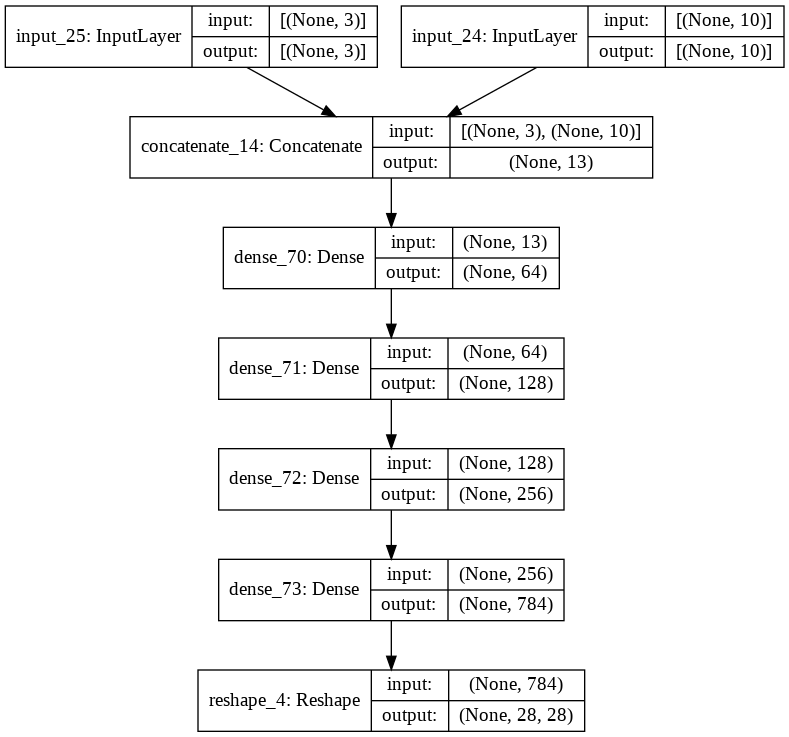

In [ ]:
c_vae_decoder_3.summary()
tf.keras.utils.plot_model(c_vae_decoder_3, show_shapes=True)

In [ ]:
encoder_out = c_vae_encoder_3([img,con])
decoder_out = c_vae_decoder_3([encoder_out,con])
c_vae_3 = tf.keras.Model([img,con], decoder_out , name = 'Conditional_VAE')

In [ ]:
# VAE 모델 컴파일 (* loss 함수가 중요!)

c_vae_3.compile(optimizer='adam',            
            #loss=tf.keras.losses.BinaryCrossentropy(reduction=tf.losses.Reduction.SUM),
            loss=tf.keras.losses.BinaryCrossentropy(),
            metrics=['mae'])

Model: "Conditional_VAE"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_23 (InputLayer)           [(None, 28, 28)]     0                                            
__________________________________________________________________________________________________
input_24 (InputLayer)           [(None, 10)]         0                                            
__________________________________________________________________________________________________
encoder (Functional)            multiple             246950      input_23[0][0]                   
                                                                 input_24[0][0]                   
__________________________________________________________________________________________________
decoder (Functional)            (None, 28, 28)       243728      encoder[1][0]      

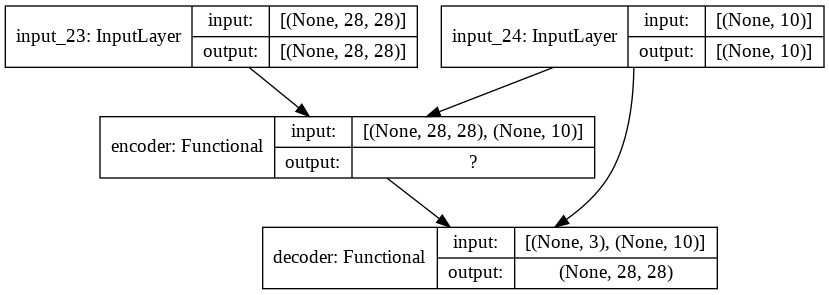

In [ ]:
c_vae_3.summary()
tf.keras.utils.plot_model(c_vae_3, show_shapes=True)

## 훈련 전, 네트워크 모델을 함수로서 활용

In [ ]:
y_pred_3 = c_vae_3([train_images,train_label_onehots])
print('input shape:', train_images.shape)
print('condition shape:', train_label_onehots.shape)
print('output shape:', y_pred_3.shape)

input shape: (60000, 28, 28)
condition shape: (60000, 10)
output shape: (60000, 28, 28)


In [ ]:
import ipywidgets as widgets

def io_imshow(idx):
  print('GT label:', train_labels[idx])
  plt.subplot(121)
  plt.imshow(train_images[idx])
  plt.subplot(122)
  plt.imshow(y_pred_3[idx])
  plt.show()

widgets.interact(io_imshow, idx=widgets.IntSlider(min=0, max=train_images.shape[0]-1, continuous_update=False));

interactive(children=(IntSlider(value=0, continuous_update=False, description='idx', max=59999), Output()), _d…

In [ ]:
z_3 = c_vae_encoder_3([train_images,train_label_onehots])
y_3 = c_vae_decoder_3([z_3.sample(), train_label_onehots])

print(z_3.shape)
print(y_3.shape)

(60000, 3)
(60000, 28, 28)


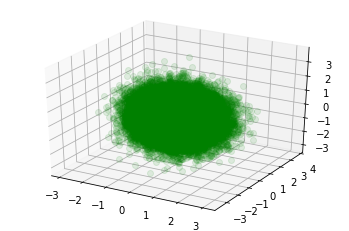

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')


ax.plot(z_3[:,0], z_3[:,1], z_3[:,2],"go", alpha=0.1)
plt.show()

In [ ]:
epochs = 20
batch_size = 100

c_vae_3.fit([train_images,train_label_onehots], train_images, epochs=epochs, batch_size=batch_size)

Epoch 1/20
600/600 [==============================] - 3s 3ms/step - loss: 0.2722 - mae: 0.1574
Epoch 2/20
600/600 [==============================] - 2s 3ms/step - loss: 0.1676 - mae: 0.0852
Epoch 3/20
600/600 [==============================] - 2s 3ms/step - loss: 0.1607 - mae: 0.0801
Epoch 4/20
600/600 [==============================] - 2s 3ms/step - loss: 0.1563 - mae: 0.0770
Epoch 5/20
600/600 [==============================] - 2s 3ms/step - loss: 0.1534 - mae: 0.0749
Epoch 6/20
600/600 [==============================] - 2s 3ms/step - loss: 0.1517 - mae: 0.0736
Epoch 7/20
600/600 [==============================] - 2s 3ms/step - loss: 0.1504 - mae: 0.0726
Epoch 8/20
600/600 [==============================] - 2s 3ms/step - loss: 0.1496 - mae: 0.0720
Epoch 9/20
600/600 [==============================] - 2s 3ms/step - loss: 0.1485 - mae: 0.0712
Epoch 10/20
600/600 [==============================] - 2s 3ms/step - loss: 0.1478 - mae: 0.0707
Epoch 11/20
600/600 [============================

In [ ]:
y_pred_3 = c_vae_3([train_images,train_label_onehots])

In [ ]:
import ipywidgets as widgets

def io_imshow(idx):
  print('GT label:', train_labels[idx])
  plt.subplot(121)
  plt.imshow(train_images[idx])
  plt.subplot(122)
  plt.imshow(y_pred_3[idx])
  plt.show()

widgets.interact(io_imshow, idx=widgets.IntSlider(min=0, max=train_images.shape[0]-1, continuous_update=False));

interactive(children=(IntSlider(value=0, continuous_update=False, description='idx', max=59999), Output()), _d…

- 이미지를 잘 생성 해냄을 확인할 수 있다.

In [ ]:
## test set에 대한 결과 

y_pred_test_3 = c_vae_3([test_images,test_label_onehots])

In [ ]:
import ipywidgets as widgets

def io_imshow(idx):
  print('GT label:', test_labels[idx])
  plt.subplot(121)
  plt.imshow(test_images[idx])
  plt.subplot(122)
  plt.imshow(y_pred_test_3[idx])
  plt.show()

widgets.interact(io_imshow, idx=widgets.IntSlider(min=0, max=test_images.shape[0]-1, continuous_update=False));

interactive(children=(IntSlider(value=0, continuous_update=False, description='idx', max=9999), Output()), _do…

- test set에 대해서도 학습을 잘 함을 확인할 수 있다.

In [ ]:
z3 = c_vae_encoder_3([train_images,train_label_onehots])
y3 = c_vae_decoder_3([z3.sample(), train_label_onehots])

print(z3.shape)
print(y3.shape)

(60000, 3)
(60000, 28, 28)


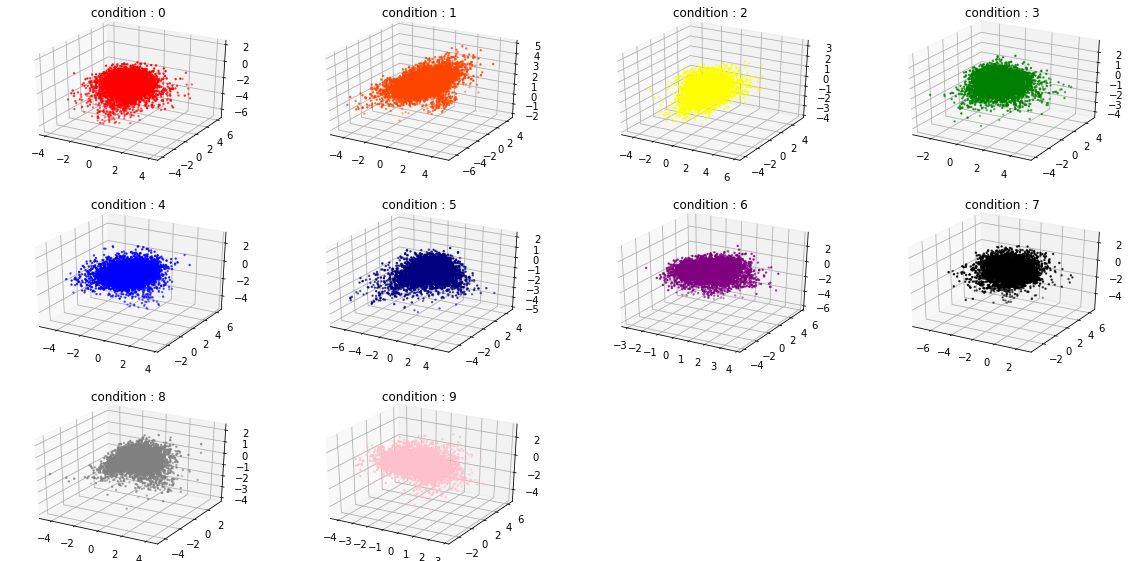

In [ ]:
z_0 = z3[train_labels==0]    # z 배열을 조건을 이용해 slice
z_1 = z3[train_labels==1]
z_2 = z3[train_labels==2]
z_3 = z3[train_labels==3]
z_4 = z3[train_labels==4]
z_5 = z3[train_labels==5]
z_6 = z3[train_labels==6]
z_7 = z3[train_labels==7]
z_8 = z3[train_labels==8]
z_9 = z3[train_labels==9]


fig = plt.figure(figsize=(20,10))

ax = fig.add_subplot(341,projection='3d')
ax.set_title('condition : 0')
ax.scatter(z_0[:,0], z_0[:,1], z_0[:,2],c = 'r',s =2)
ax = fig.add_subplot(342,projection='3d')
ax.set_title('condition : 1')
ax.scatter(z_1[:,0], z_1[:,1], z_1[:,2],c = 'orangered',s =2)
ax = fig.add_subplot(343,projection='3d')
ax.set_title('condition : 2')
ax.scatter(z_2[:,0], z_2[:,1], z_2[:,2],c = 'yellow',s =2)
ax = fig.add_subplot(344,projection='3d')
ax.set_title('condition : 3')
ax.scatter(z_3[:,0], z_3[:,1], z_3[:,2],c = 'green',s =2)
ax = fig.add_subplot(345,projection='3d')
ax.set_title('condition : 4')
ax.scatter(z_4[:,0], z_4[:,1], z_4[:,2],c = 'b',s =2)
ax = fig.add_subplot(346,projection='3d')
ax.set_title('condition : 5')
ax.scatter(z_5[:,0], z_5[:,1], z_5[:,2],c = 'navy',s =2)
ax = fig.add_subplot(347,projection='3d')
ax.set_title('condition : 6')
ax.scatter(z_6[:,0], z_6[:,1], z_6[:,2],c = 'purple',s =2)
ax = fig.add_subplot(348,projection='3d')
ax.set_title('condition : 7')
ax.scatter(z_7[:,0], z_7[:,1], z_7[:,2],c = 'black',s =2)
ax = fig.add_subplot(349,projection='3d')
ax.set_title('condition : 8')
ax.scatter(z_8[:,0], z_8[:,1], z_8[:,2],c = 'gray',s =2)
ax = fig.add_subplot(3,4,10,projection='3d')
ax.set_title('condition : 9')
ax.scatter(z_9[:,0], z_9[:,1], z_9[:,2],c = 'pink',s =2)

plt.show()

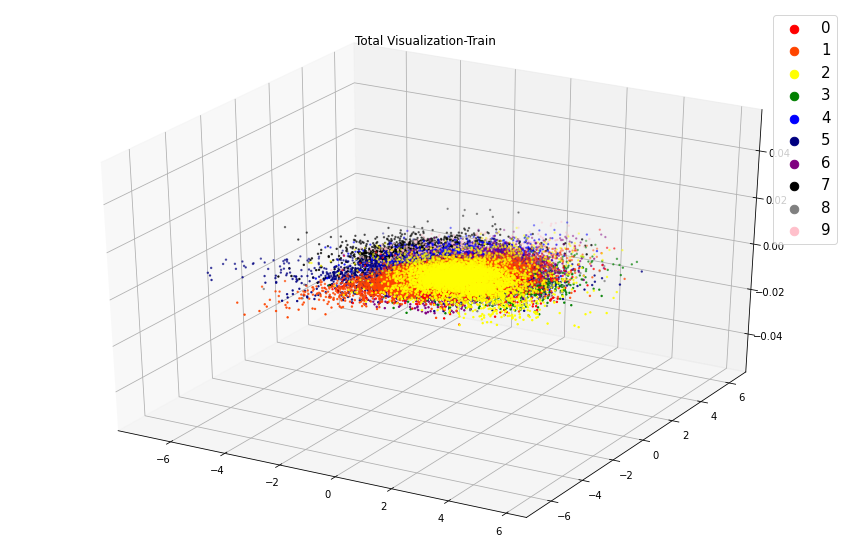

In [ ]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection='3d')
ax.set_title("Total Visualization-Train")

ax.scatter(z_0[:,0], z_0[:,1], c = 'r', s =2)
ax.scatter(z_1[:,0], z_1[:,1], c = 'orangered',s =2)
ax.scatter(z_2[:,0], z_2[:,1], c = 'yellow',s =2)
ax.scatter(z_3[:,0], z_3[:,1], c = 'green',s =2)
ax.scatter(z_4[:,0], z_4[:,1], c = 'b',s =2)
ax.scatter(z_5[:,0], z_5[:,1], c = 'navy',s =2)
ax.scatter(z_6[:,0], z_6[:,1], c = 'purple',s =2)
ax.scatter(z_7[:,0], z_7[:,1], c = 'black',s =2)
ax.scatter(z_8[:,0], z_8[:,1], c = 'gray',s =2)
ax.scatter(z_9[:,0], z_9[:,1], c = 'pink',s =2)

plt.legend([0,1,2,3,4,5,6,7,8,9], fontsize = 15, markerscale=6)
plt.show()

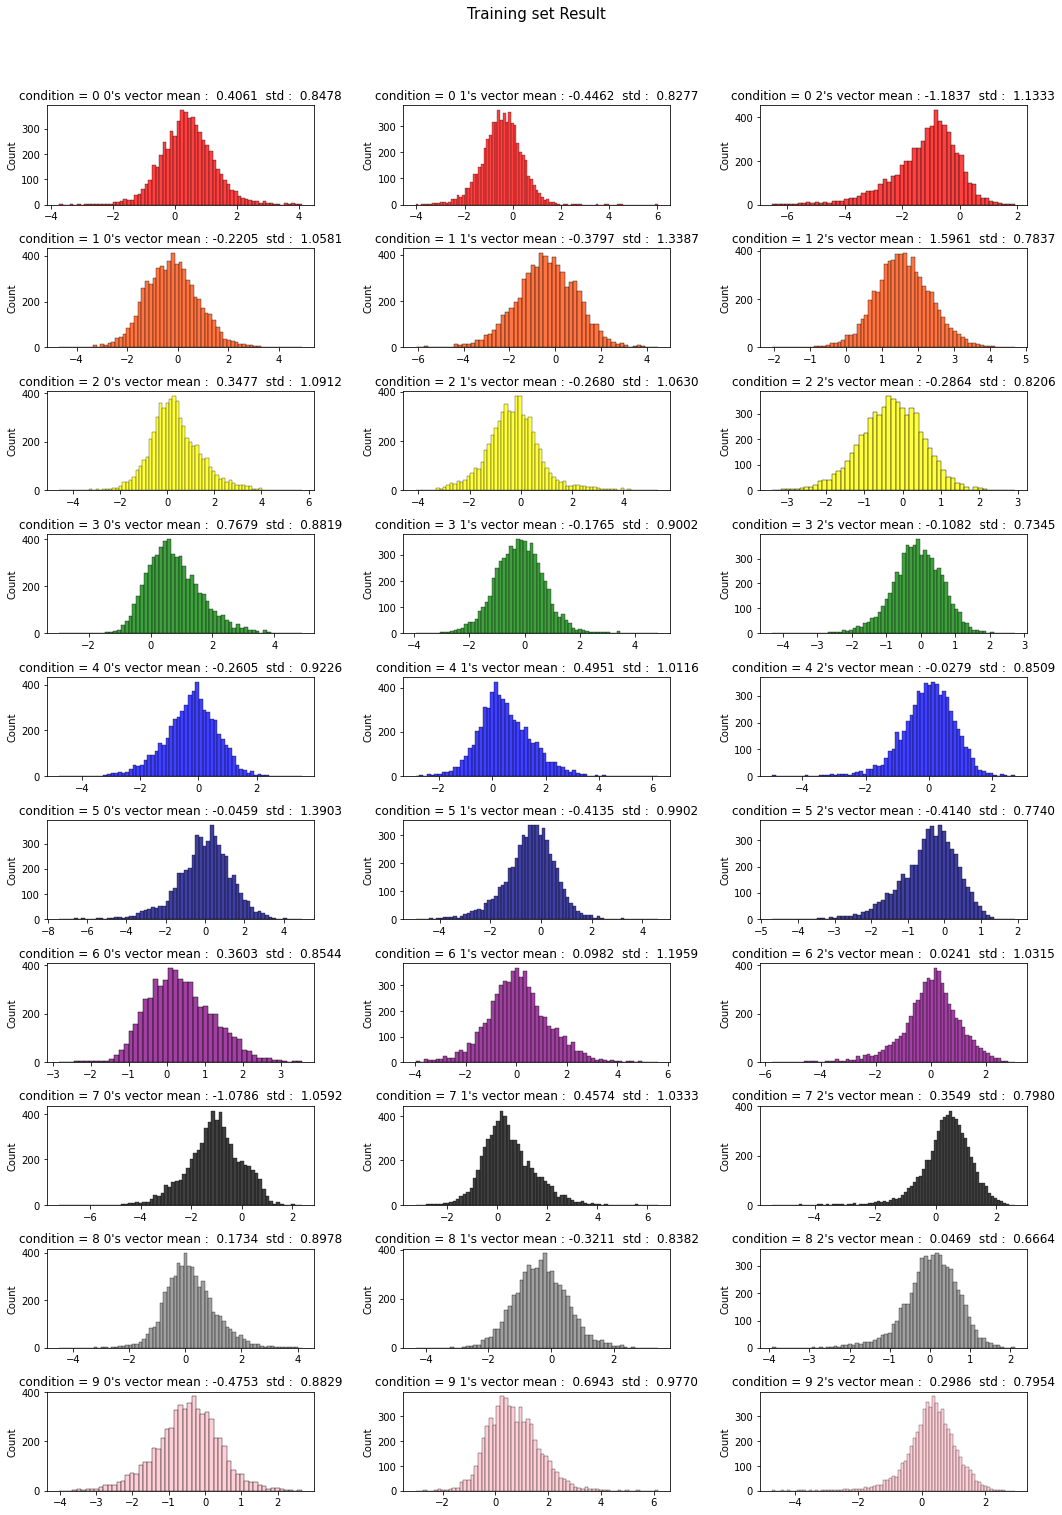

In [ ]:
z_list = [z_0,z_1,z_2,z_3,z_4,z_5,z_6,z_7,z_8,z_9]
color_list = ['r', 'orangered', 'yellow', 'green', 'b', 'navy', 'purple', 'black', 'gray', 'pink']
f, axes = plt.subplots(10,3 , figsize = (15,20))
axes = axes.flatten()

j = 0
for i in range(0,10) :
  mean = np.mean(z_list[i][:,0])
  std = np.std(z_list[i][:,0])
  sns.histplot(z_list[i][:,0] ,ax = axes[j], color= color_list[i])
  axes[j].set_title(f"condition = {i} 0's vector mean : {mean : .4f}  std : {std : .4f}")
  j += 1
  
  mean = np.mean(z_list[i][:,1])
  std = np.std(z_list[i][:,1])
  sns.histplot(z_list[i][:,1] ,ax = axes[j], color = color_list[i])
  axes[j].set_title(f"condition = {i} 1's vector mean : {mean : .4f}  std : {std : .4f}")
  j += 1

  mean = np.mean(z_list[i][:,2])
  std = np.std(z_list[i][:,2])
  sns.histplot(z_list[i][:,2] ,ax = axes[j], color = color_list[i])
  axes[j].set_title(f"condition = {i} 2's vector mean : {mean : .4f}  std : {std : .4f}")
  j += 1

plt.suptitle('Training set Result', y = 1.05, fontsize = 15)
plt.tight_layout()
plt.show()

- latent vector z에 대하여 시각화를 한 경우 위의 n_dim =2 와 동일하게 condition = 0, 1 일때, 3번째 차원에 대해서를 제외하고 prior 분포인 정규분포 $N(0,1^2)$를 보여주고 있다.

### Test set 에 대한 결과 확인

In [ ]:
z_test3 = c_vae_encoder_3([test_images,test_label_onehots])
y_test3 = c_vae_decoder_3([z_test3.sample(),test_label_onehots])

print(z_test3.shape)
print(y_test3.shape)

(10000, 3)
(10000, 28, 28)


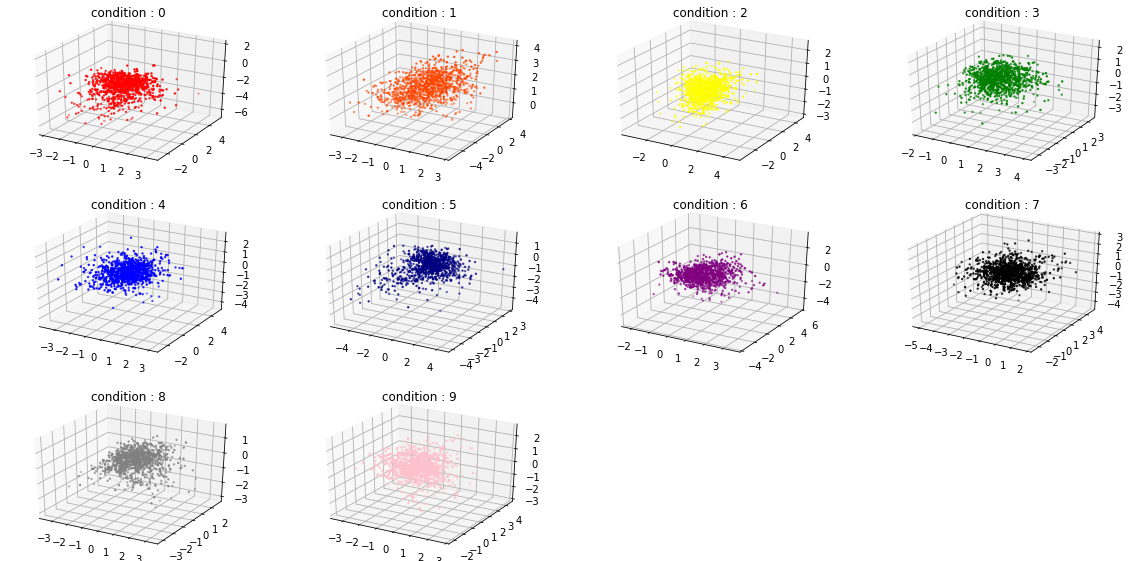

In [ ]:
z_0 = z_test3[test_labels==0]    # z 배열을 조건을 이용해 slice
z_1 = z_test3[test_labels==1]
z_2 = z_test3[test_labels==2]
z_3 = z_test3[test_labels==3]
z_4 = z_test3[test_labels==4]
z_5 = z_test3[test_labels==5]
z_6 = z_test3[test_labels==6]
z_7 = z_test3[test_labels==7]
z_8 = z_test3[test_labels==8]
z_9 = z_test3[test_labels==9]


fig = plt.figure(figsize=(20,10))

ax = fig.add_subplot(341,projection='3d')
ax.set_title('condition : 0')
ax.scatter(z_0[:,0], z_0[:,1], z_0[:,2],c = 'r',s =2)
ax = fig.add_subplot(342,projection='3d')
ax.set_title('condition : 1')
ax.scatter(z_1[:,0], z_1[:,1], z_1[:,2],c = 'orangered',s =2)
ax = fig.add_subplot(343,projection='3d')
ax.set_title('condition : 2')
ax.scatter(z_2[:,0], z_2[:,1], z_2[:,2],c = 'yellow',s =2)
ax = fig.add_subplot(344,projection='3d')
ax.set_title('condition : 3')
ax.scatter(z_3[:,0], z_3[:,1], z_3[:,2],c = 'green',s =2)
ax = fig.add_subplot(345,projection='3d')
ax.set_title('condition : 4')
ax.scatter(z_4[:,0], z_4[:,1], z_4[:,2],c = 'b',s =2)
ax = fig.add_subplot(346,projection='3d')
ax.set_title('condition : 5')
ax.scatter(z_5[:,0], z_5[:,1], z_5[:,2],c = 'navy',s =2)
ax = fig.add_subplot(347,projection='3d')
ax.set_title('condition : 6')
ax.scatter(z_6[:,0], z_6[:,1], z_6[:,2],c = 'purple',s =2)
ax = fig.add_subplot(348,projection='3d')
ax.set_title('condition : 7')
ax.scatter(z_7[:,0], z_7[:,1], z_7[:,2],c = 'black',s =2)
ax = fig.add_subplot(349,projection='3d')
ax.set_title('condition : 8')
ax.scatter(z_8[:,0], z_8[:,1], z_8[:,2],c = 'gray',s =2)
ax = fig.add_subplot(3,4,10,projection='3d')
ax.set_title('condition : 9')
ax.scatter(z_9[:,0], z_9[:,1], z_9[:,2],c = 'pink',s =2)

plt.show()

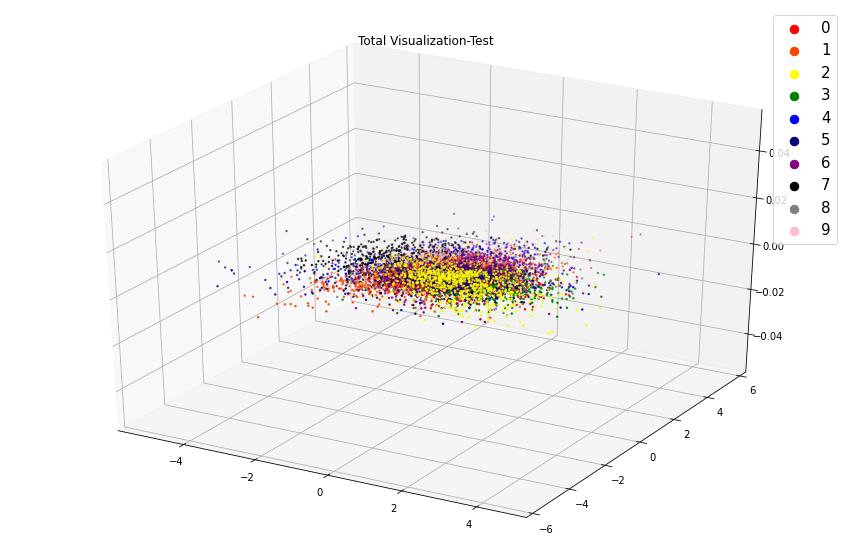

In [ ]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection='3d')
ax.set_title("Total Visualization-Test")

ax.scatter(z_0[:,0], z_0[:,1], c = 'r', s =2)
ax.scatter(z_1[:,0], z_1[:,1], c = 'orangered',s =2)
ax.scatter(z_2[:,0], z_2[:,1], c = 'yellow',s =2)
ax.scatter(z_3[:,0], z_3[:,1], c = 'green',s =2)
ax.scatter(z_4[:,0], z_4[:,1], c = 'b',s =2)
ax.scatter(z_5[:,0], z_5[:,1], c = 'navy',s =2)
ax.scatter(z_6[:,0], z_6[:,1], c = 'purple',s =2)
ax.scatter(z_7[:,0], z_7[:,1], c = 'black',s =2)
ax.scatter(z_8[:,0], z_8[:,1], c = 'gray',s =2)
ax.scatter(z_9[:,0], z_9[:,1], c = 'pink',s =2)

plt.legend([0,1,2,3,4,5,6,7,8,9], fontsize = 15, markerscale=6)
plt.show()

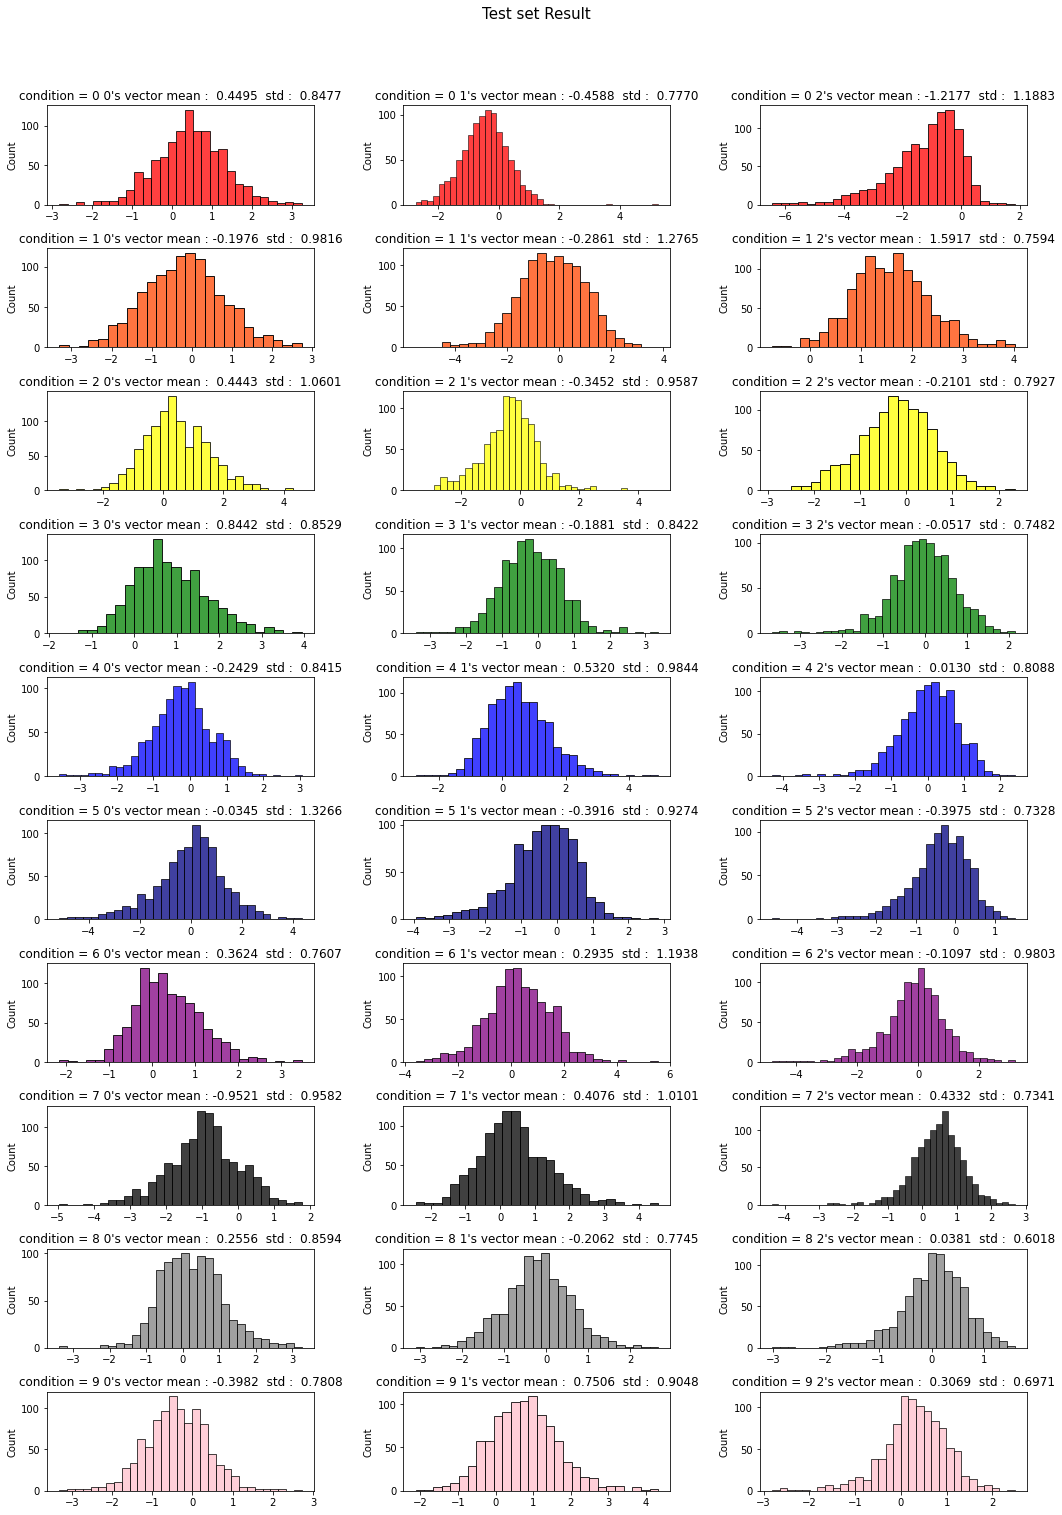

In [ ]:
z_list = [z_0,z_1,z_2,z_3,z_4,z_5,z_6,z_7,z_8,z_9]
color_list = ['r', 'orangered', 'yellow', 'green', 'b', 'navy', 'purple', 'black', 'gray', 'pink']
f, axes = plt.subplots(10,3 , figsize = (15,20))
axes = axes.flatten()

j = 0
for i in range(0,10) :
  mean = np.mean(z_list[i][:,0])
  std = np.std(z_list[i][:,0])
  sns.histplot(z_list[i][:,0] ,ax = axes[j], color= color_list[i])
  axes[j].set_title(f"condition = {i} 0's vector mean : {mean : .4f}  std : {std : .4f}")
  j += 1
  
  mean = np.mean(z_list[i][:,1])
  std = np.std(z_list[i][:,1])
  sns.histplot(z_list[i][:,1] ,ax = axes[j], color = color_list[i])
  axes[j].set_title(f"condition = {i} 1's vector mean : {mean : .4f}  std : {std : .4f}")
  j += 1

  mean = np.mean(z_list[i][:,2])
  std = np.std(z_list[i][:,2])
  sns.histplot(z_list[i][:,2] ,ax = axes[j], color = color_list[i])
  axes[j].set_title(f"condition = {i} 2's vector mean : {mean : .4f}  std : {std : .4f}")
  j += 1

plt.suptitle('Test set Result', y = 1.05, fontsize = 15)
plt.tight_layout()
plt.show()

- test set의 latent vector z에 대하여 시각화를 한 경우 위의 n_dim =2 와 동일하게 condition = 0, 1 일때, 3번째 차원에 대해서를 제외하고 prior 분포인 정규분포  $N(0,1^2)$ 를 보여주고 있다.

- test set에도 적용이 잘 되는것을 확인할 수 있다.

- 1 :  q(z|x)  에서 뽑인 z값에 대한 이미지 생성 결과

In [ ]:
def z_show(idx):
  print(z3[idx])
  print('GT label:', train_labels[idx])

widgets.interact(z_show, idx=widgets.IntSlider(min=0, max=train_images.shape[0]-1));

interactive(children=(IntSlider(value=0, description='idx', max=59999), Output()), _dom_classes=('widget-inter…

In [ ]:
## 디코더의 테스트 입력 설정

import ipywidgets as widgets

u=widgets.FloatSlider(min=-5.0, max=5.0)
v=widgets.FloatSlider(min=-5.0, max=5.0)
w=widgets.FloatSlider(min=-5.0, max=5.0)

ui = widgets.HBox([u,v,w])

def z_test(u, v, w):
  z_test = np.array([[u,v,w]])  
  c_test = np.array([[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]]) # ground truth : 6 라는 condition을 부여
  print(z_test)

  img_gen = c_vae_decoder_3([z_test, c_test])
  plt.imshow(img_gen[0])
  plt.show()  

out = widgets.interactive_output(z_test, {'u': u, 'v': v, 'w': w})

display(ui, out)

Output()

- q(z|x)에서 idx = 27992에 대하여 뽑힌 z 값 (1.79, 0.31, -1.11) GT : 6을 decoder의 input으로 넣었을 경우 output을 시각화 해보면, 이미지를 상당히 잘 만들어 내는 것을 확인할 수 있다.

- p(z)  : 위에서 정의된 prior에 대하여 sampling한 z에 대한 결과

In [ ]:
prior_sample = prior.sample(sample_shape=(10))
prior_sample

<tf.Tensor: shape=(10, 3), dtype=float32, numpy=
array([[ 1.4282984 ,  1.4009498 , -0.91554296],
       [-0.39475608,  0.9193321 , -0.33547392],
       [ 1.8320243 ,  0.9870794 , -1.6503416 ],
       [-1.371231  ,  1.1070528 , -1.4340801 ],
       [ 0.4896289 , -0.9763245 ,  1.2966968 ],
       [ 0.87830853,  0.3572213 ,  0.5415113 ],
       [ 0.01454183,  0.32352656,  0.07308978],
       [ 0.53777736,  1.7836783 , -0.23449047],
       [ 0.6599591 ,  0.10200514,  0.0104614 ],
       [-1.593487  ,  1.1921028 , -0.17209016]], dtype=float32)>

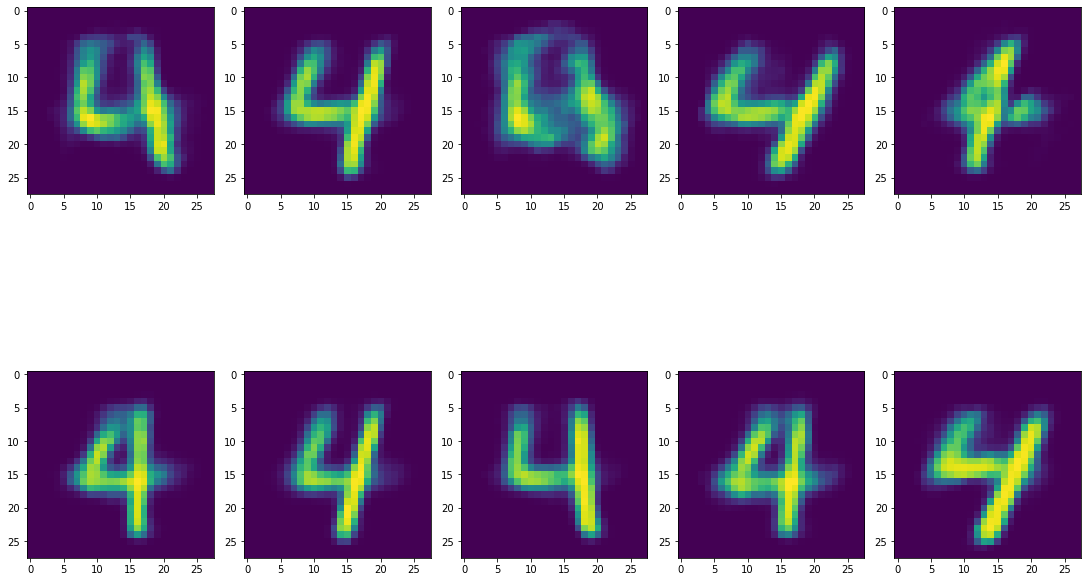

In [ ]:
f, axes = plt.subplots(2,5 , figsize = (15,10), constrained_layout=True)
axes = axes.flatten()

for i in range(len(prior_sample)) :
  z_sample = np.array([prior_sample[i]])
  condition_sample = np.array([[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]]) # GT = 4 로 condition 부여 
  img_gen = c_vae_decoder_3([z_sample, condition_sample])
  axes[i].imshow(img_gen[0])
plt.show()

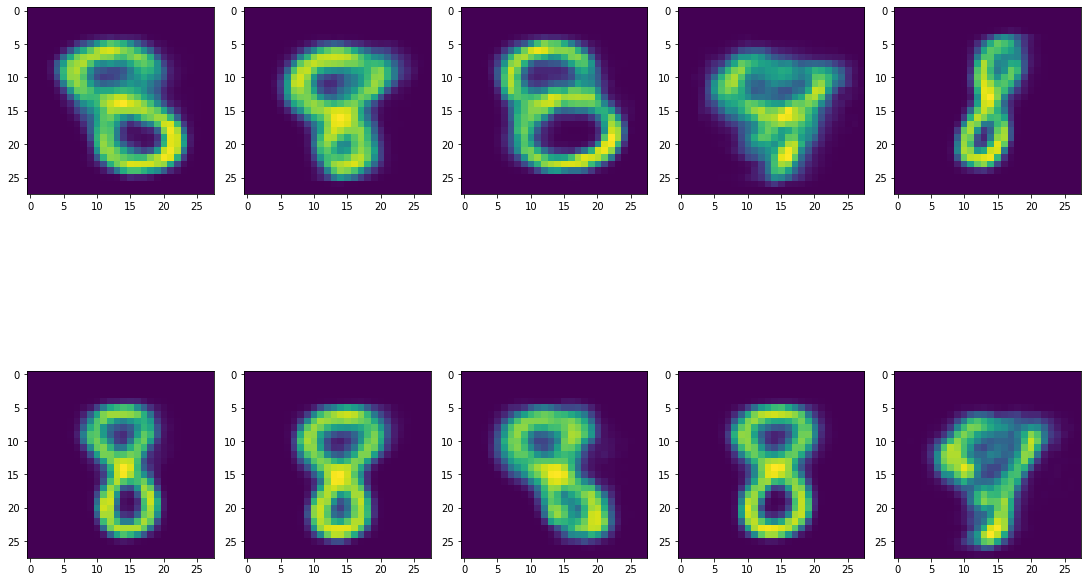

In [ ]:
f, axes = plt.subplots(2,5 , figsize = (15,10), constrained_layout=True)
axes = axes.flatten()

for i in range(len(prior_sample)) :
  z_sample = np.array([prior_sample[i]])
  condition_sample = np.array([[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]]) # GT = 8 로 condition 부여 
  img_gen = c_vae_decoder_3([z_sample, condition_sample])
  axes[i].imshow(img_gen[0])
plt.show()

- 결과를 확인해 보면 , prior 분포인 p(z)에서 sampling한 z값에 대해서도 condition을 결합하면 이미지 생성을 잘 해냄을 확인할 수 있지만, 몇몇의 random한 sample에 대해서는 결과가 안좋은것을 확인할 수 있다. 이를 해결하기 위해 추가적으로 실험을 더 해보도록 하겠다.

### Adversarial AutoEncoder

- VAE를 학습할 때, KL DivergenceRegularizer를 통해 p(z)와 q(z|x)의 분포 차이를 조정하였는데 , 이는 GAN의 학습 방법과 유사하다고 보아 이러한 KL DivergenceRegularizer 역할을 GAN으로 대체하는 방법이다. 

- 이전 VAE와 다르게 prior에서 sampling된 z에 대한 정보를 통해 학습이 되다 보니 Adversarial AutoEncoder는 prior에 가깝게 학습이 되고, VAE는 기존에 tfp.IndependentNormal layer에 의해 학습이 되다 보니 prior 보다는 IndependentNormal의 Normal distribution에 가깝게 학습된다라는 차이점이 존재한다.

- [Adversarial AE](https://arxiv.org/abs/1511.05644)

In [ ]:
tfd = tfp.distributions

enc_dim = 2

prior = tfd.Independent(tfd.Normal(loc=tf.zeros(enc_dim), scale=1), # p(z) 에 관한 함수
                        reinterpreted_batch_ndims=1)

In [ ]:
img = tf.keras.Input(shape = (28,28))

enc_flat = tf.keras.layers.Flatten()
enc_dense1 = tf.keras.layers.Dense(256, activation = 'relu')
enc_dense2 = tf.keras.layers.Dense(128, activation='relu')
enc_dense3 = tf.keras.layers.Dense(64, activation= 'relu')
enc_proba = tf.keras.layers.Dense(enc_dim)

x = enc_flat(img)
x = enc_dense1(x)
x = enc_dense2(x)
x = enc_dense3(x)
z = enc_proba(x)

vae_encoder = tf.keras.Model(inputs = img, outputs= z, name = 'encoder')

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_38 (InputLayer)        [(None, 28, 28)]          0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_140 (Dense)            (None, 256)               200960    
_________________________________________________________________
dense_141 (Dense)            (None, 128)               32896     
_________________________________________________________________
dense_142 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_143 (Dense)            (None, 2)                 130       
Total params: 242,242
Trainable params: 242,242
Non-trainable params: 0
_____________________________________________________

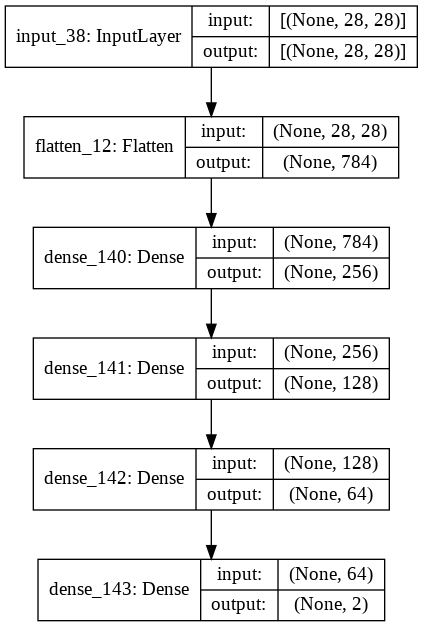

In [ ]:
vae_encoder.summary()
tf.keras.utils.plot_model(vae_encoder, show_shapes=True)

In [ ]:
dec_z = tf.keras.layers.Input(shape = (enc_dim,))
dec_dense_1 = tf.keras.layers.Dense(64, activation='relu')
dec_dense_2 = tf.keras.layers.Dense(128, activation='relu')
dec_dense_3 = tf.keras.layers.Dense(256, activation='relu')
dec_dense_4 = tf.keras.layers.Dense(28*28, activation='sigmoid')
dec_reshape = tf.keras.layers.Reshape(target_shape=(28,28))



x = dec_dense_1(dec_z)
x = dec_dense_2(x)
x = dec_dense_3(x)
x = dec_dense_4(x)
y_pred = dec_reshape(x)

vae_decoder = tf.keras.Model(inputs = dec_z, outputs = y_pred, name = 'decoder')

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_39 (InputLayer)        [(None, 2)]               0         
_________________________________________________________________
dense_144 (Dense)            (None, 64)                192       
_________________________________________________________________
dense_145 (Dense)            (None, 128)               8320      
_________________________________________________________________
dense_146 (Dense)            (None, 256)               33024     
_________________________________________________________________
dense_147 (Dense)            (None, 784)               201488    
_________________________________________________________________
reshape_12 (Reshape)         (None, 28, 28)            0         
Total params: 243,024
Trainable params: 243,024
Non-trainable params: 0
_____________________________________________________

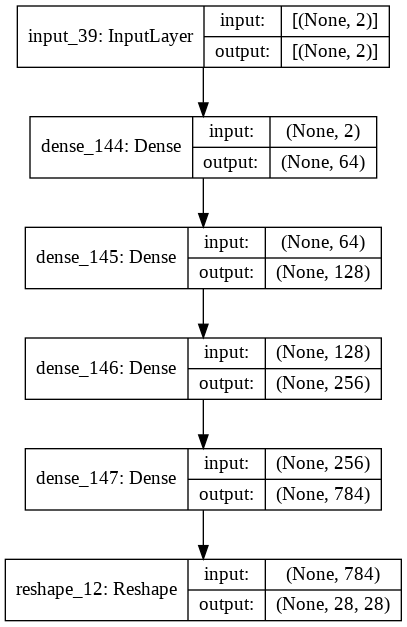

In [ ]:
vae_decoder.summary()
tf.keras.utils.plot_model(vae_decoder, show_shapes=True)

In [ ]:
# discriminator 부분
dis_z = tf.keras.layers.Input(shape = (enc_dim,))
dis_dense_1 = tf.keras.layers.Dense(256, activation='relu')
dis_dense_2 = tf.keras.layers.Dense(128, activation='relu')
dis_dense_3 = tf.keras.layers.Dense(64, activation='relu')
dis_dense_4 = tf.keras.layers.Dense(1, activation='sigmoid')


x = dis_dense_1(dis_z)
x = dis_dense_2(x)
x = dis_dense_3(x)
dis_pred = dis_dense_4(x)

discriminator = tf.keras.Model(inputs = dis_z, outputs = dis_pred, name = 'discriminator')

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_40 (InputLayer)        [(None, 2)]               0         
_________________________________________________________________
dense_148 (Dense)            (None, 256)               768       
_________________________________________________________________
dense_149 (Dense)            (None, 128)               32896     
_________________________________________________________________
dense_150 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_151 (Dense)            (None, 1)                 65        
Total params: 41,985
Trainable params: 41,985
Non-trainable params: 0
_________________________________________________________________


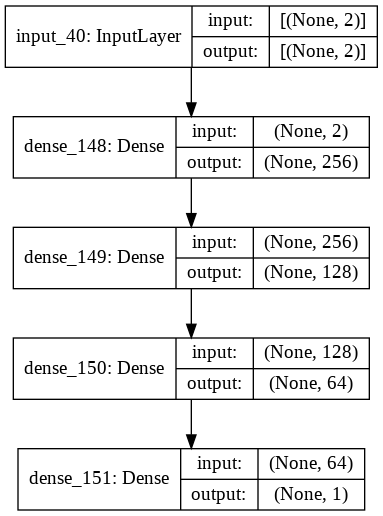

In [ ]:
discriminator.summary()
tf.keras.utils.plot_model(discriminator, show_shapes=True)

In [ ]:
discriminator.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),            
            loss=tf.keras.losses.BinaryCrossentropy(),
            metrics=['acc'])

In [ ]:
# discriminator의 optimizer와 loss를 적용시켜준 후 학습을 해야하는것은 generator (Encoder - Decoder 부분) 이기 때문에 trainable = False로 설정해 준다.
discriminator.trainable = False

encoder_out = vae_encoder(img)
decoder_out = vae_decoder(encoder_out)

validity = discriminator(encoder_out)
adversarial_ae = tf.keras.Model(img, [decoder_out, validity] , name = 'Adversarial_AE')

Model: "Adversarial_AE"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_38 (InputLayer)           [(None, 28, 28)]     0                                            
__________________________________________________________________________________________________
encoder (Functional)            (None, 2)            242242      input_38[0][0]                   
__________________________________________________________________________________________________
decoder (Functional)            (None, 28, 28)       243024      encoder[0][0]                    
__________________________________________________________________________________________________
discriminator (Functional)      (None, 1)            41985       encoder[0][0]                    
Total params: 527,251
Trainable params: 485,266
Non-trainable params: 41,985
________

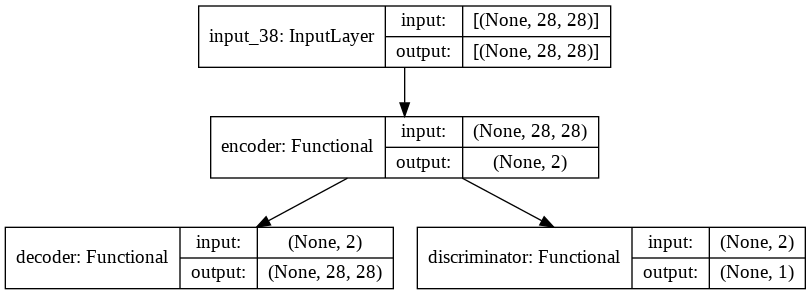

In [ ]:
adversarial_ae.summary()
tf.keras.utils.plot_model(adversarial_ae, show_shapes=True)

In [ ]:
# 여기서 중요한 것은 실제 이미지와 생성된 이미지간의 loss이기 때문에 mae에 가중치를 주고, discriminator가 real, fake 를 구분하는 loss에 대해서는 적은 가중치를 부여한다.
adversarial_ae.compile(optimizer='adam',            
            loss=['mae', 'binary_crossentropy'],
            loss_weights = [0.999, 0.001])

In [ ]:
def sample_prior(batch_size) : # 기존에 정의된 prior에서 sampling을 진행하여 학습에 보내는 함수이다.
  return prior.sample(sample_shape=(batch_size))

In [ ]:
batch_size = 100
epochs = 20 * 600

real_label = np.ones((batch_size, 1))
fake_label = np.zeros((batch_size, 1))

for epoch in range(epochs) :
  idx = tf.convert_to_tensor(np.random.randint(0, train_images.shape[0], batch_size))

  batch_data = tf.gather(train_images, idx)

  # Encoding된 latent vector를 fake로 설정
  latent_fake = vae_encoder.predict(batch_data)
  # Prior에서 sampling된 latent vector를 real로 설정
  latent_real = sample_prior(batch_size)

  d_loss_real = discriminator.train_on_batch(latent_real, real_label)
  d_loss_fake = discriminator.train_on_batch(latent_fake, fake_label)
  d_loss = 0.5 * tf.math.add(d_loss_real, d_loss_fake)


  g_loss = adversarial_ae.train_on_batch(batch_data, [batch_data, real_label])

  if epoch % 600 == 0 :
    print(f"{epoch // 600}'s [D loss : {d_loss[0] : .4f}, acc : {100*d_loss[1] : .2f}%] [G loss : {g_loss[0] : .4f}, mae : {g_loss[1] : .4f}]")

0's [D loss :  0.7077, acc :  50.00%] [G loss :  0.4711, mae :  0.4709]
1's [D loss :  0.6620, acc :  55.50%] [G loss :  0.1056, mae :  0.1049]
2's [D loss :  0.6617, acc :  60.50%] [G loss :  0.1027, mae :  0.1020]
3's [D loss :  0.6551, acc :  59.50%] [G loss :  0.0984, mae :  0.0977]
4's [D loss :  0.6840, acc :  52.50%] [G loss :  0.0907, mae :  0.0901]
5's [D loss :  0.6825, acc :  54.00%] [G loss :  0.0947, mae :  0.0940]
6's [D loss :  0.6756, acc :  52.50%] [G loss :  0.0906, mae :  0.0898]
7's [D loss :  0.6820, acc :  54.50%] [G loss :  0.0925, mae :  0.0918]
8's [D loss :  0.6554, acc :  61.50%] [G loss :  0.0901, mae :  0.0894]
9's [D loss :  0.7122, acc :  54.00%] [G loss :  0.0934, mae :  0.0927]
10's [D loss :  0.6539, acc :  61.50%] [G loss :  0.0874, mae :  0.0867]
11's [D loss :  0.6461, acc :  65.50%] [G loss :  0.0872, mae :  0.0865]
12's [D loss :  0.6412, acc :  63.00%] [G loss :  0.0849, mae :  0.0842]
13's [D loss :  0.6817, acc :  57.00%] [G loss :  0.0845, mae

In [ ]:
y_pred, _ = adversarial_ae(train_images)

In [ ]:
import ipywidgets as widgets

def io_imshow(idx):
  print('GT label:', train_labels[idx])
  plt.subplot(121)
  plt.imshow(train_images[idx])
  plt.subplot(122)
  plt.imshow(y_pred[idx])
  plt.show()

widgets.interact(io_imshow, idx=widgets.IntSlider(min=0, max=train_images.shape[0]-1, continuous_update=False));

interactive(children=(IntSlider(value=0, continuous_update=False, description='idx', max=59999), Output()), _d…

In [ ]:
y_pred_test, _ = adversarial_ae(test_images)

In [ ]:
import ipywidgets as widgets

def io_imshow(idx):
  print('GT label:', test_labels[idx])
  plt.subplot(121)
  plt.imshow(test_images[idx])
  plt.subplot(122)
  plt.imshow(y_pred_test[idx])
  plt.show()

widgets.interact(io_imshow, idx=widgets.IntSlider(min=0, max=test_images.shape[0]-1, continuous_update=False));

interactive(children=(IntSlider(value=0, continuous_update=False, description='idx', max=9999), Output()), _do…

- Adversarial AutoEncoder의 결과를 확인해 보면, 어느 정도 이미지를 생성하지만, 기존 epochs 30으로는 원하는 결과를 얻기 힘들어 보인다.

In [ ]:
z = vae_encoder(train_images)
y = vae_decoder(z)

print(z.shape)
print(y.shape)

(60000, 2)
(60000, 28, 28)


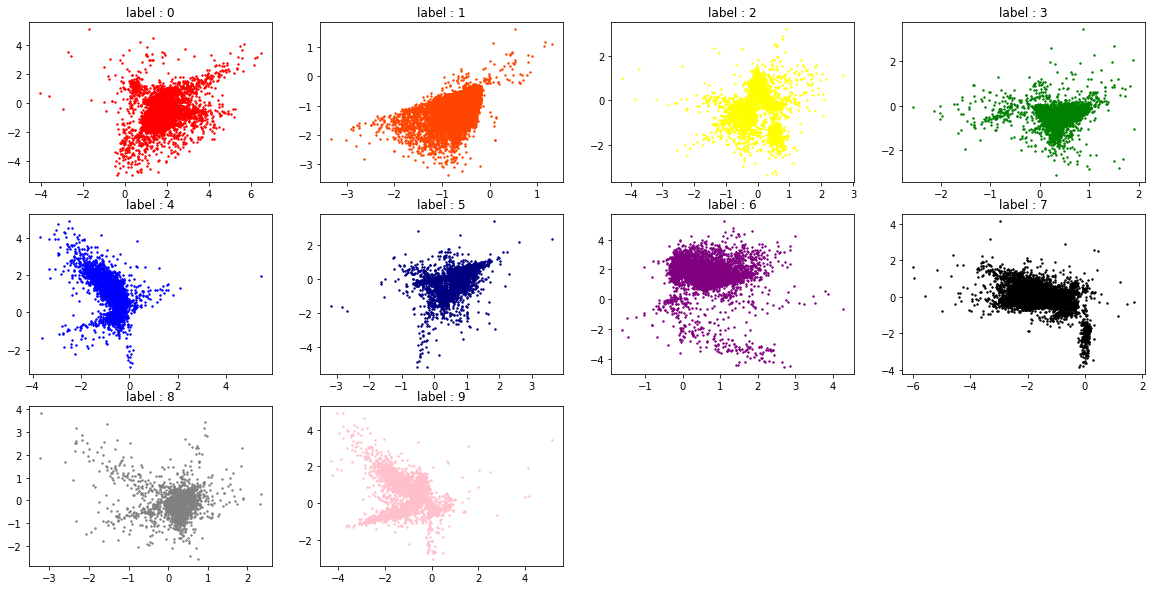

In [ ]:
z_0 = z[train_labels==0]    # z 배열을 조건을 이용해 slice
z_1 = z[train_labels==1]
z_2 = z[train_labels==2]
z_3 = z[train_labels==3]
z_4 = z[train_labels==4]
z_5 = z[train_labels==5]
z_6 = z[train_labels==6]
z_7 = z[train_labels==7]
z_8 = z[train_labels==8]
z_9 = z[train_labels==9]

plt.figure(figsize=(20,10))
plt.tight_layout()

plt.subplot(341)
plt.title('label : 0')
plt.scatter(z_0[:,0], z_0[:,1], c = 'r', s =2)
plt.subplot(342)
plt.title('label : 1')
plt.scatter(z_1[:,0], z_1[:,1], c = 'orangered',s =2)
plt.subplot(343)
plt.title('label : 2')
plt.scatter(z_2[:,0], z_2[:,1], c = 'yellow',s =2)
plt.subplot(344)
plt.title('label : 3')
plt.scatter(z_3[:,0], z_3[:,1], c = 'green',s =2)
plt.subplot(345)
plt.title('label : 4')
plt.scatter(z_4[:,0], z_4[:,1], c = 'b',s =2)
plt.subplot(346)
plt.title('label : 5')
plt.scatter(z_5[:,0], z_5[:,1], c = 'navy',s =2)
plt.subplot(347)
plt.title('label : 6')
plt.scatter(z_6[:,0], z_6[:,1], c = 'purple',s =2)
plt.subplot(348)
plt.title('label : 7')
plt.scatter(z_7[:,0], z_7[:,1], c = 'black',s =2)
plt.subplot(349)
plt.title('label : 8')
plt.scatter(z_8[:,0], z_8[:,1], c = 'gray',s =2)
plt.subplot(3,4,10)
plt.title('label : 9')
plt.scatter(z_9[:,0], z_9[:,1], c = 'pink',s =2)

plt.show()

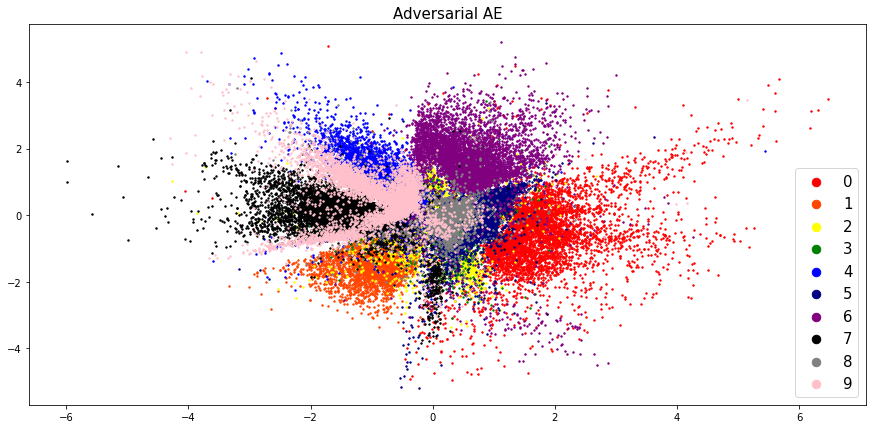

In [ ]:
plt.figure(figsize=(15,7))
plt.title('Adversarial AE', fontsize = 15)

plt.scatter(z_0[:,0], z_0[:,1], c = 'r', s =2)
plt.scatter(z_1[:,0], z_1[:,1], c = 'orangered',s =2)
plt.scatter(z_2[:,0], z_2[:,1], c = 'yellow',s =2)
plt.scatter(z_3[:,0], z_3[:,1], c = 'green',s =2)
plt.scatter(z_4[:,0], z_4[:,1], c = 'b',s =2)
plt.scatter(z_5[:,0], z_5[:,1], c = 'navy',s =2)
plt.scatter(z_6[:,0], z_6[:,1], c = 'purple',s =2)
plt.scatter(z_7[:,0], z_7[:,1], c = 'black',s =2)
plt.scatter(z_8[:,0], z_8[:,1], c = 'gray',s =2)
plt.scatter(z_9[:,0], z_9[:,1], c = 'pink',s =2)

plt.legend([0,1,2,3,4,5,6,7,8,9], fontsize = 15, markerscale=6)
plt.show()

- condition을 주지 않은 상태에서도 우리의 바람과 동일하게 z가 분포된다.

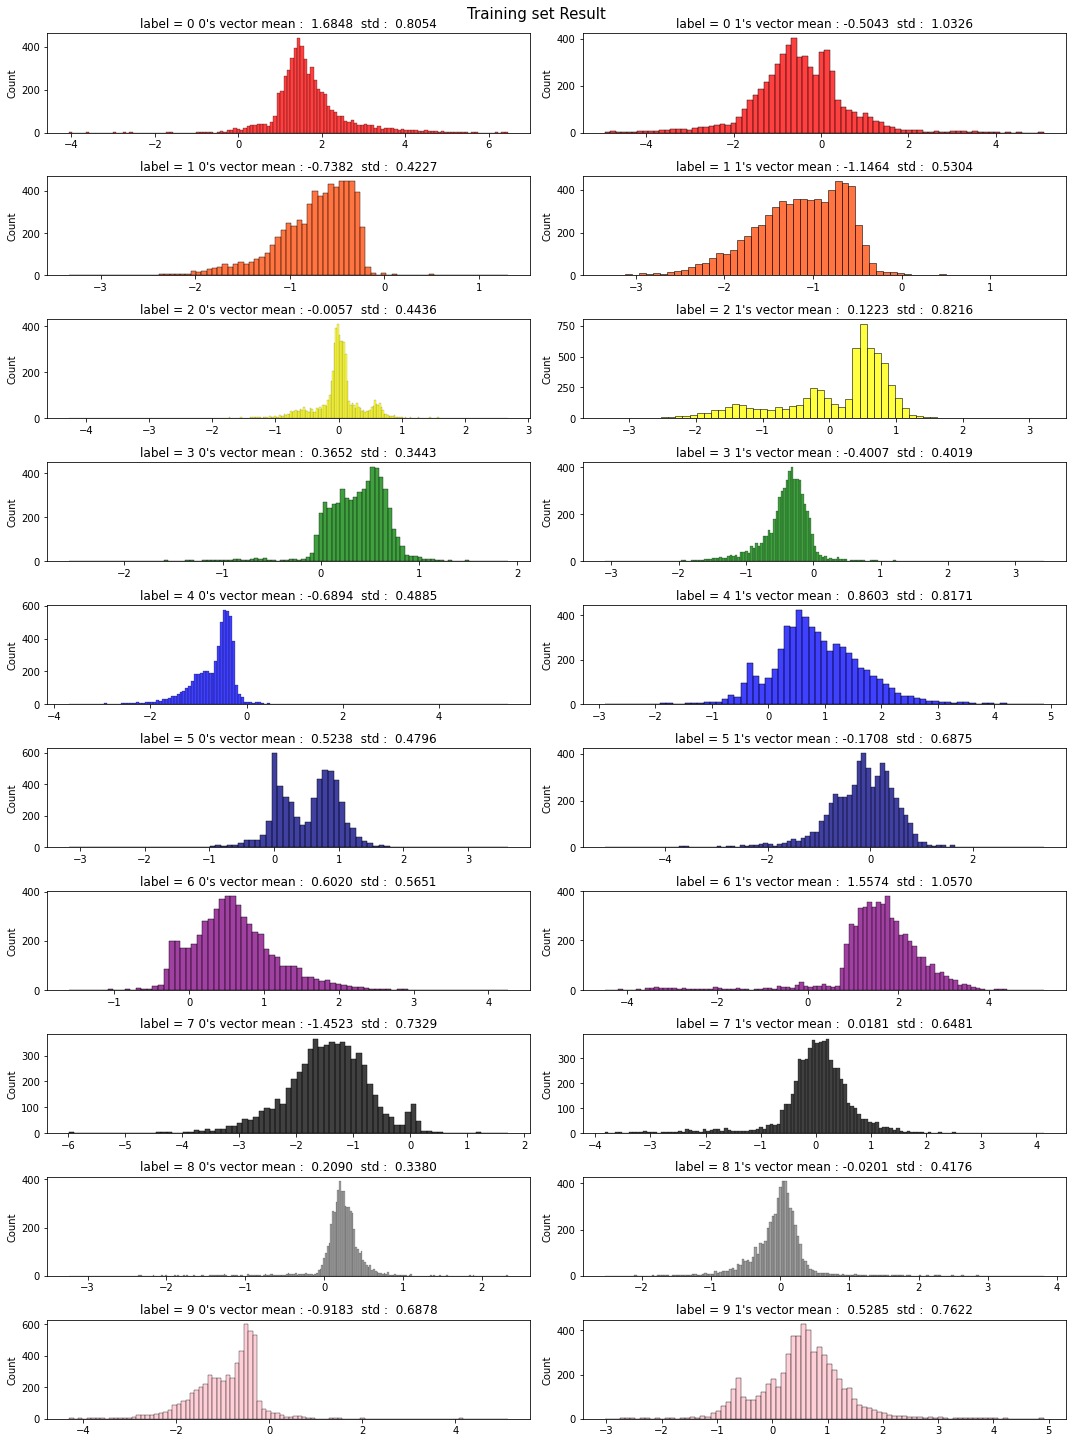

In [ ]:
import seaborn as sns

z_list = [z_0,z_1,z_2,z_3,z_4,z_5,z_6,z_7,z_8,z_9]
color_list = ['r', 'orangered', 'yellow', 'green', 'b', 'navy', 'purple', 'black', 'gray', 'pink']
f, axes = plt.subplots(10,2 , figsize = (15,20))
axes = axes.flatten()

j = 0
for i in range(0,10) :
  mean = np.mean(z_list[i][:,0])
  std = np.std(z_list[i][:,0])
  sns.histplot(z_list[i][:,0] ,ax = axes[j], color= color_list[i])
  axes[j].set_title(f"label = {i} 0's vector mean : {mean : .4f}  std : {std : .4f}")
  j += 1
  
  mean = np.mean(z_list[i][:,1])
  std = np.std(z_list[i][:,1])
  sns.histplot(z_list[i][:,1] ,ax = axes[j], color = color_list[i])
  axes[j].set_title(f"label = {i} 1's vector mean : {mean : .4f}  std : {std : .4f}")
  j += 1

plt.suptitle('Training set Result', y = 1, fontsize = 15)
plt.tight_layout()
plt.show()

- 결과를 확인해 보면, 단순히 Gaussian Distribution에 가깝게 학습되기 보다 prior에서 sampling된 분포와 가깝게 만들려고 학습을 진행한다.

In [ ]:
z_test = vae_encoder(test_images)
y_test = vae_decoder(z_test)

print(z_test.shape)
print(y_test.shape)

(10000, 2)
(10000, 28, 28)


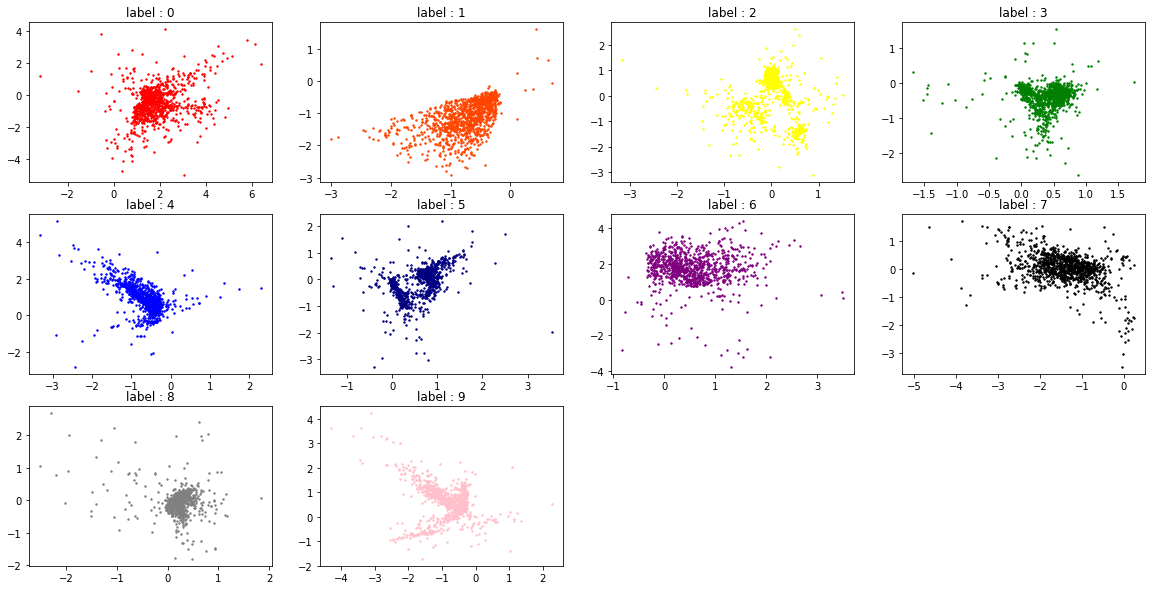

In [ ]:
z_0 = z_test[test_labels==0]    # z 배열을 조건을 이용해 slice
z_1 = z_test[test_labels==1]
z_2 = z_test[test_labels==2]
z_3 = z_test[test_labels==3]
z_4 = z_test[test_labels==4]
z_5 = z_test[test_labels==5]
z_6 = z_test[test_labels==6]
z_7 = z_test[test_labels==7]
z_8 = z_test[test_labels==8]
z_9 = z_test[test_labels==9]

plt.figure(figsize=(20,10))
plt.tight_layout()

plt.subplot(341)
plt.title('label : 0')
plt.scatter(z_0[:,0], z_0[:,1], c = 'r', s =2)
plt.subplot(342)
plt.title('label : 1')
plt.scatter(z_1[:,0], z_1[:,1], c = 'orangered',s =2)
plt.subplot(343)
plt.title('label : 2')
plt.scatter(z_2[:,0], z_2[:,1], c = 'yellow',s =2)
plt.subplot(344)
plt.title('label : 3')
plt.scatter(z_3[:,0], z_3[:,1], c = 'green',s =2)
plt.subplot(345)
plt.title('label : 4')
plt.scatter(z_4[:,0], z_4[:,1], c = 'b',s =2)
plt.subplot(346)
plt.title('label : 5')
plt.scatter(z_5[:,0], z_5[:,1], c = 'navy',s =2)
plt.subplot(347)
plt.title('label : 6')
plt.scatter(z_6[:,0], z_6[:,1], c = 'purple',s =2)
plt.subplot(348)
plt.title('label : 7')
plt.scatter(z_7[:,0], z_7[:,1], c = 'black',s =2)
plt.subplot(349)
plt.title('label : 8')
plt.scatter(z_8[:,0], z_8[:,1], c = 'gray',s =2)
plt.subplot(3,4,10)
plt.title('label : 9')
plt.scatter(z_9[:,0], z_9[:,1], c = 'pink',s =2)

plt.show()

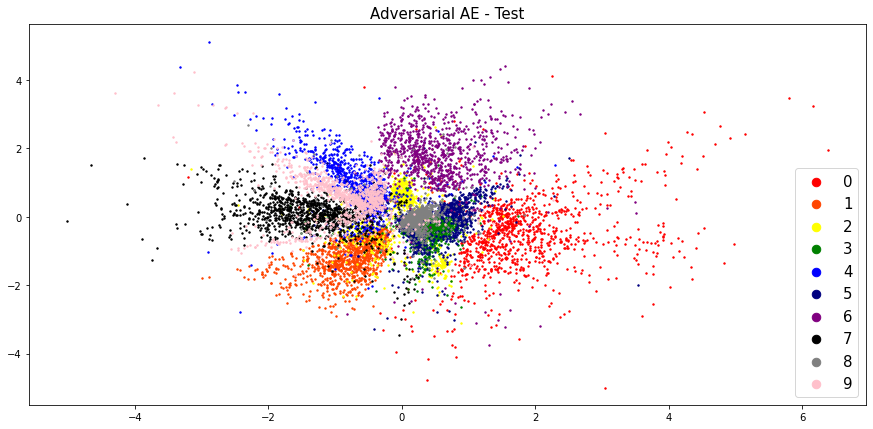

In [ ]:
plt.figure(figsize=(15,7))
plt.title('Adversarial AE - Test', fontsize = 15)

plt.scatter(z_0[:,0], z_0[:,1], c = 'r', s =2)
plt.scatter(z_1[:,0], z_1[:,1], c = 'orangered',s =2)
plt.scatter(z_2[:,0], z_2[:,1], c = 'yellow',s =2)
plt.scatter(z_3[:,0], z_3[:,1], c = 'green',s =2)
plt.scatter(z_4[:,0], z_4[:,1], c = 'b',s =2)
plt.scatter(z_5[:,0], z_5[:,1], c = 'navy',s =2)
plt.scatter(z_6[:,0], z_6[:,1], c = 'purple',s =2)
plt.scatter(z_7[:,0], z_7[:,1], c = 'black',s =2)
plt.scatter(z_8[:,0], z_8[:,1], c = 'gray',s =2)
plt.scatter(z_9[:,0], z_9[:,1], c = 'pink',s =2)

plt.legend([0,1,2,3,4,5,6,7,8,9], fontsize = 15, markerscale=6)
plt.show()

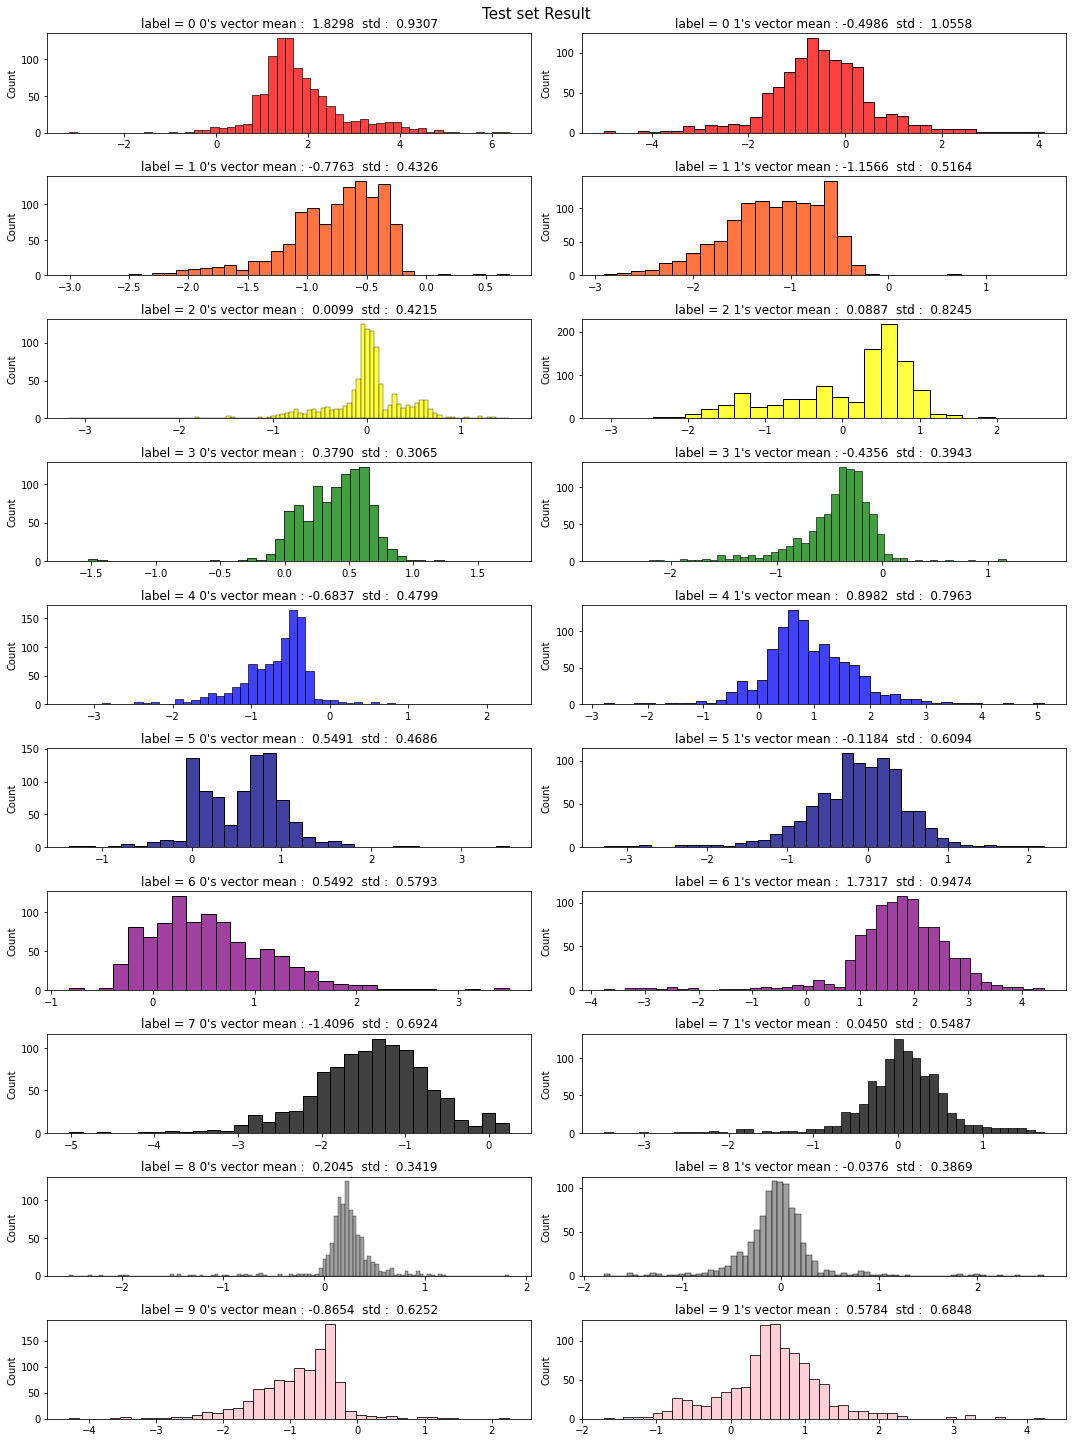

In [ ]:
import seaborn as sns

z_list = [z_0,z_1,z_2,z_3,z_4,z_5,z_6,z_7,z_8,z_9]
color_list = ['r', 'orangered', 'yellow', 'green', 'b', 'navy', 'purple', 'black', 'gray', 'pink']
f, axes = plt.subplots(10,2 , figsize = (15,20))
axes = axes.flatten()

j = 0
for i in range(0,10) :
  mean = np.mean(z_list[i][:,0])
  std = np.std(z_list[i][:,0])
  sns.histplot(z_list[i][:,0] ,ax = axes[j], color= color_list[i])
  axes[j].set_title(f"label = {i} 0's vector mean : {mean : .4f}  std : {std : .4f}")
  j += 1
  
  mean = np.mean(z_list[i][:,1])
  std = np.std(z_list[i][:,1])
  sns.histplot(z_list[i][:,1] ,ax = axes[j], color = color_list[i])
  axes[j].set_title(f"label = {i} 1's vector mean : {mean : .4f}  std : {std : .4f}")
  j += 1

plt.suptitle('Test set Result', y = 1, fontsize = 15)
plt.tight_layout()
plt.show()

- Test set에 대해서도 단순히 Gaussian Distribution에 가깝게 학습되기 보다 prior에서 sampling된 분포와 가깝게 만들려고 학습을 진행한다

In [ ]:
z = vae_encoder(train_images)
y = vae_decoder(z)

print(z.shape)
print(y.shape)

def z_show(idx):
  print(z[idx])
  print('GT label:', train_labels[idx])

widgets.interact(z_show, idx=widgets.IntSlider(min=0, max=train_images.shape[0]-1));

(60000, 2)
(60000, 28, 28)


interactive(children=(IntSlider(value=0, description='idx', max=59999), Output()), _dom_classes=('widget-inter…

In [ ]:
## 디코더의 테스트 입력 설정

import ipywidgets as widgets

u=widgets.FloatSlider(min=-5.0, max=5.0)
v=widgets.FloatSlider(min=-5.0, max=5.0)

ui = widgets.HBox([u,v])

def z_test(u, v):
  z_test = np.array([[u,v]])  
  print(z_test)

  img_gen = vae_decoder(z_test)
  plt.imshow(img_gen[0])
  plt.show()  

out = widgets.interactive_output(z_test, {'u': u, 'v': v})

display(ui, out)

Output()

- q(z|x)에서 idx = 5517에 대하여 뽑힌 z 값 (-0.915, 0.174) GT : 6을 decoder의 input으로 넣었을 경우 output을 시각화 해보면, 어느정도 6에 가까운 이미지를 만들어 냄을 확인할 수 있다.

-  이제 이러한 Adversarial AutoEncoder에 Condition을 추가한 Conditional Adversarial AutoEncoder를 통해 과제를 수행해 보겠다.

### Conditional Adversarial AutoEncoder

In [ ]:
tfd = tfp.distributions

enc_dim = 2

prior = tfd.Independent(tfd.Normal(loc=tf.zeros(enc_dim), scale=1), # p(z) 에 관한 함수
                        reinterpreted_batch_ndims=1)

In [ ]:
img = tf.keras.Input(shape = (28,28))
con = tf.keras.Input(shape = (10,))

enc_flat = tf.keras.layers.Flatten()
enc_dense1 = tf.keras.layers.Dense(256, activation = 'relu')
enc_dense2 = tf.keras.layers.Dense(128, activation='relu')
enc_dense3 = tf.keras.layers.Dense(64, activation= 'relu')
enc_proba = tf.keras.layers.Dense(enc_dim)

x = enc_flat(img)
x = tf.keras.layers.concatenate([x, con])
x = enc_dense1(x)
x = enc_dense2(x)
x = enc_dense3(x)
z = enc_proba(x)

c_vae_encoder = tf.keras.Model(inputs = [img, con], outputs= z, name = 'aae_encoder')

Model: "aae_encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_41 (InputLayer)           [(None, 28, 28)]     0                                            
__________________________________________________________________________________________________
flatten_13 (Flatten)            (None, 784)          0           input_41[0][0]                   
__________________________________________________________________________________________________
input_42 (InputLayer)           [(None, 10)]         0                                            
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 794)          0           flatten_13[0][0]                 
                                                                 input_42[0][0]         

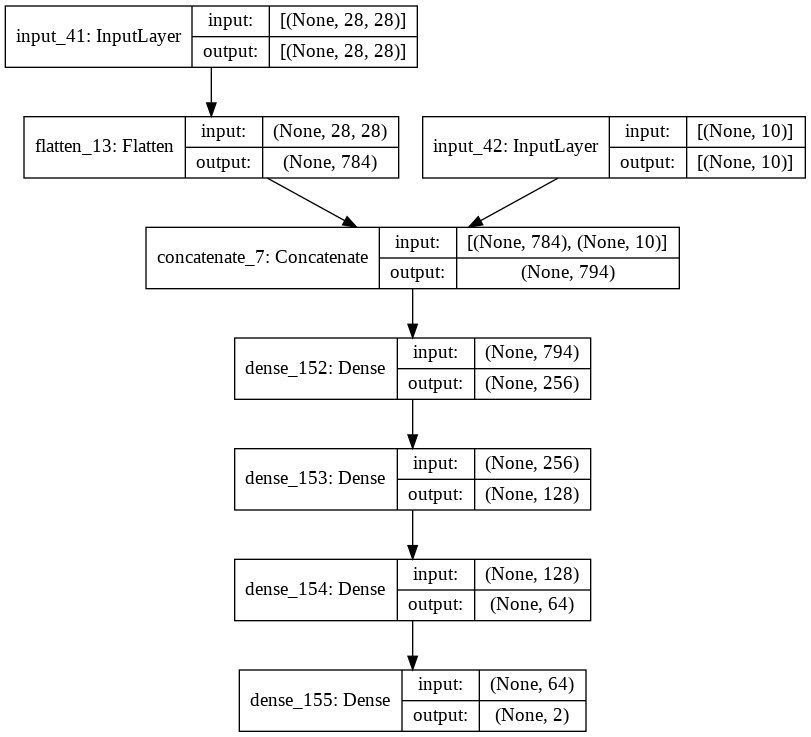

In [ ]:
c_vae_encoder.summary()
tf.keras.utils.plot_model(c_vae_encoder, show_shapes=True)

In [ ]:
dec_z = tf.keras.layers.Input(shape = (enc_dim,))
dec_dense_1 = tf.keras.layers.Dense(64, activation='relu')
dec_dense_2 = tf.keras.layers.Dense(128, activation='relu')
dec_dense_3 = tf.keras.layers.Dense(256, activation='relu')
dec_dense_4 = tf.keras.layers.Dense(28*28, activation='sigmoid')
dec_reshape = tf.keras.layers.Reshape(target_shape=(28,28))


x = tf.keras.layers.concatenate([dec_z, con])
x = dec_dense_1(x)
x = dec_dense_2(x)
x = dec_dense_3(x)
x = dec_dense_4(x)
y_pred = dec_reshape(x)

c_vae_decoder = tf.keras.Model(inputs = [dec_z, con], outputs = y_pred, name = 'aae_decoder')

Model: "aae_decoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_43 (InputLayer)           [(None, 2)]          0                                            
__________________________________________________________________________________________________
input_42 (InputLayer)           [(None, 10)]         0                                            
__________________________________________________________________________________________________
concatenate_8 (Concatenate)     (None, 12)           0           input_43[0][0]                   
                                                                 input_42[0][0]                   
__________________________________________________________________________________________________
dense_156 (Dense)               (None, 64)           832         concatenate_8[0][0]    

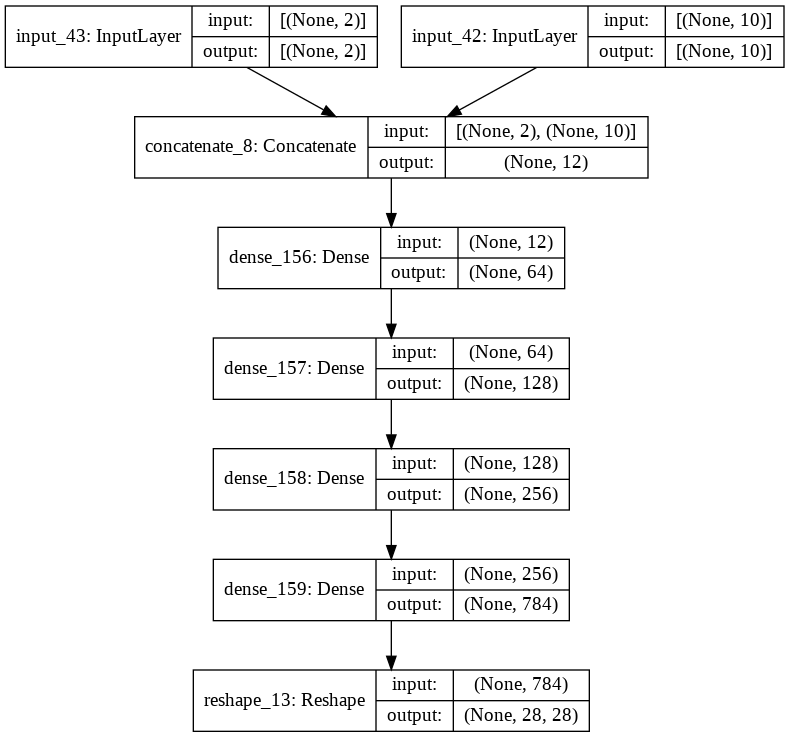

In [ ]:
c_vae_decoder.summary()
tf.keras.utils.plot_model(c_vae_decoder, show_shapes=True)

In [ ]:
dis_z = tf.keras.layers.Input(shape = (enc_dim,))
dis_dense_1 = tf.keras.layers.Dense(256, activation='relu')
dis_dense_2 = tf.keras.layers.Dense(128, activation='relu')
dis_dense_3 = tf.keras.layers.Dense(64, activation='relu')
dis_dense_4 = tf.keras.layers.Dense(1, activation='sigmoid')

x = tf.keras.layers.concatenate([dis_z, con])
x = dis_dense_1(x)
x = dis_dense_2(x)
x = dis_dense_3(x)
dis_pred = dis_dense_4(x)

discriminator = tf.keras.Model(inputs = [dis_z, con], outputs = dis_pred, name = 'discriminator')

Model: "discriminator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_44 (InputLayer)           [(None, 2)]          0                                            
__________________________________________________________________________________________________
input_42 (InputLayer)           [(None, 10)]         0                                            
__________________________________________________________________________________________________
concatenate_9 (Concatenate)     (None, 12)           0           input_44[0][0]                   
                                                                 input_42[0][0]                   
__________________________________________________________________________________________________
dense_160 (Dense)               (None, 256)          3328        concatenate_9[0][0]  

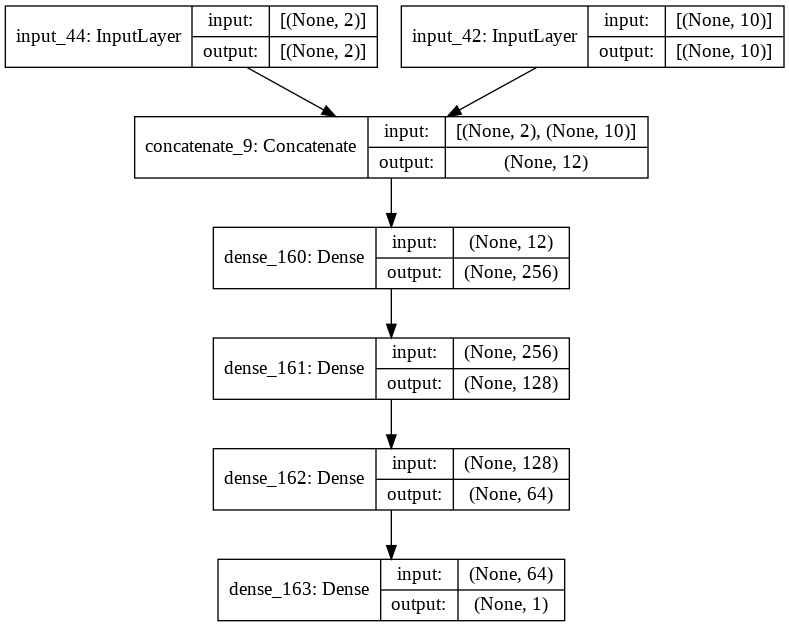

In [ ]:
discriminator.summary()
tf.keras.utils.plot_model(discriminator, show_shapes=True)

In [ ]:
discriminator.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),            
            loss=tf.keras.losses.BinaryCrossentropy(),
            metrics=['acc'])

In [ ]:
discriminator.trainable = False

encoder_out = c_vae_encoder([img, con])
decoder_out = c_vae_decoder([encoder_out,con])

validity = discriminator([encoder_out, con])
c_adversarial_ae = tf.keras.Model([img, con], [decoder_out, validity] , name = 'Conditional_Adversarial_AE')

Model: "Conditional_Adversarial_AE"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_41 (InputLayer)           [(None, 28, 28)]     0                                            
__________________________________________________________________________________________________
input_42 (InputLayer)           [(None, 10)]         0                                            
__________________________________________________________________________________________________
aae_encoder (Functional)        (None, 2)            244802      input_41[0][0]                   
                                                                 input_42[0][0]                   
__________________________________________________________________________________________________
aae_decoder (Functional)        (None, 28, 28)       243664      aae_enco

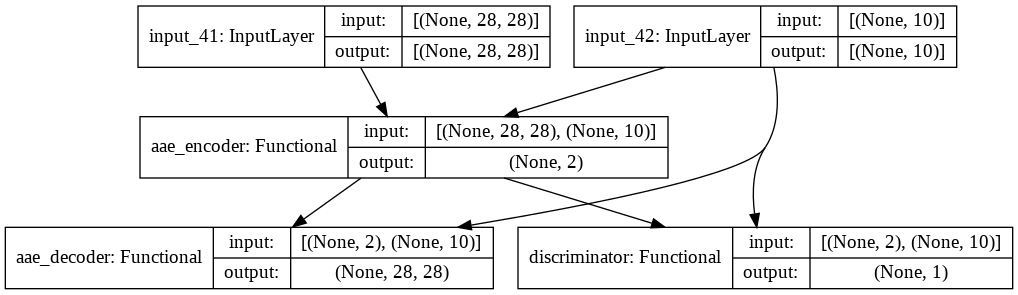

In [ ]:
c_adversarial_ae.summary()
tf.keras.utils.plot_model(c_adversarial_ae, show_shapes=True)

In [ ]:
c_adversarial_ae.compile(optimizer='adam',            
            loss=['mae', 'binary_crossentropy'],
            loss_weights = [0.999, 0.001])

In [ ]:
def sample_prior(batch_size) :
  return prior.sample(sample_shape=(batch_size))

In [ ]:
batch_size = 100
epochs = 20 * 600

real_label = np.ones((batch_size, 1))
fake_label = np.zeros((batch_size, 1))

for epoch in range(epochs) :
  idx = np.random.randint(0, train_images.shape[0], batch_size)
  tensor_idx = tf.convert_to_tensor(idx)

  batch_data = tf.gather(train_images, tensor_idx)
  batch_con = train_label_onehots[idx]

  latent_fake = c_vae_encoder([batch_data, batch_con])
  latent_real = sample_prior(batch_size)

  d_loss_real = discriminator.train_on_batch([latent_real, batch_con], real_label)
  d_loss_fake = discriminator.train_on_batch([latent_fake, batch_con], fake_label)
  d_loss = 0.5 * tf.math.add(d_loss_real, d_loss_fake)


  g_loss = c_adversarial_ae.train_on_batch([batch_data, batch_con], [batch_data, real_label])

  if epoch % 600 == 0 :
    print(f"{epoch // 600}'s [D loss : {d_loss[0] : .4f}, acc : {100*d_loss[1] : .2f}%] [G loss : {g_loss[0] : .4f}, mae : {g_loss[1] : .4f}]")

0's [D loss :  0.6874, acc :  55.50%] [G loss :  0.4724, mae :  0.4721]
1's [D loss :  0.6185, acc :  65.00%] [G loss :  0.1011, mae :  0.1003]
2's [D loss :  0.6194, acc :  64.50%] [G loss :  0.0784, mae :  0.0776]
3's [D loss :  0.6409, acc :  62.00%] [G loss :  0.0782, mae :  0.0774]
4's [D loss :  0.6585, acc :  67.00%] [G loss :  0.0769, mae :  0.0761]
5's [D loss :  0.6750, acc :  54.00%] [G loss :  0.0752, mae :  0.0744]
6's [D loss :  0.6564, acc :  60.50%] [G loss :  0.0717, mae :  0.0710]
7's [D loss :  0.6632, acc :  59.00%] [G loss :  0.0733, mae :  0.0725]
8's [D loss :  0.6742, acc :  57.00%] [G loss :  0.0687, mae :  0.0680]
9's [D loss :  0.6631, acc :  61.50%] [G loss :  0.0702, mae :  0.0695]
10's [D loss :  0.6656, acc :  59.00%] [G loss :  0.0732, mae :  0.0725]
11's [D loss :  0.6611, acc :  57.00%] [G loss :  0.0704, mae :  0.0696]
12's [D loss :  0.6738, acc :  55.00%] [G loss :  0.0692, mae :  0.0686]
13's [D loss :  0.6586, acc :  56.50%] [G loss :  0.0691, mae

In [ ]:
y_pred, _ = c_adversarial_ae([train_images,train_label_onehots])

In [ ]:
import ipywidgets as widgets

def io_imshow(idx):
  print('GT label:', train_labels[idx])
  plt.subplot(121)
  plt.imshow(train_images[idx])
  plt.subplot(122)
  plt.imshow(y_pred[idx])
  plt.show()

widgets.interact(io_imshow, idx=widgets.IntSlider(min=0, max=train_images.shape[0]-1, continuous_update=False));

interactive(children=(IntSlider(value=0, continuous_update=False, description='idx', max=59999), Output()), _d…

In [ ]:
y_pred_test, _ = c_adversarial_ae([test_images,test_label_onehots])

In [ ]:
import ipywidgets as widgets

def io_imshow(idx):
  print('GT label:', test_labels[idx])
  plt.subplot(121)
  plt.imshow(test_images[idx])
  plt.subplot(122)
  plt.imshow(y_pred_test[idx])
  plt.show()

widgets.interact(io_imshow, idx=widgets.IntSlider(min=0, max=test_images.shape[0]-1, continuous_update=False));

interactive(children=(IntSlider(value=0, continuous_update=False, description='idx', max=9999), Output()), _do…

- 앞에서 실행한 AAE 보다 Conditional AAE가 이미지를 잘 생성함을 볼 수 있다, 또한 conditional VAE 만큼 이미지를 잘 생성해냄을 확인할 수 있다.

In [ ]:
z = c_vae_encoder([train_images,train_label_onehots])
y = c_vae_decoder([z, train_label_onehots])

print(z.shape)
print(y.shape)

(60000, 2)
(60000, 28, 28)


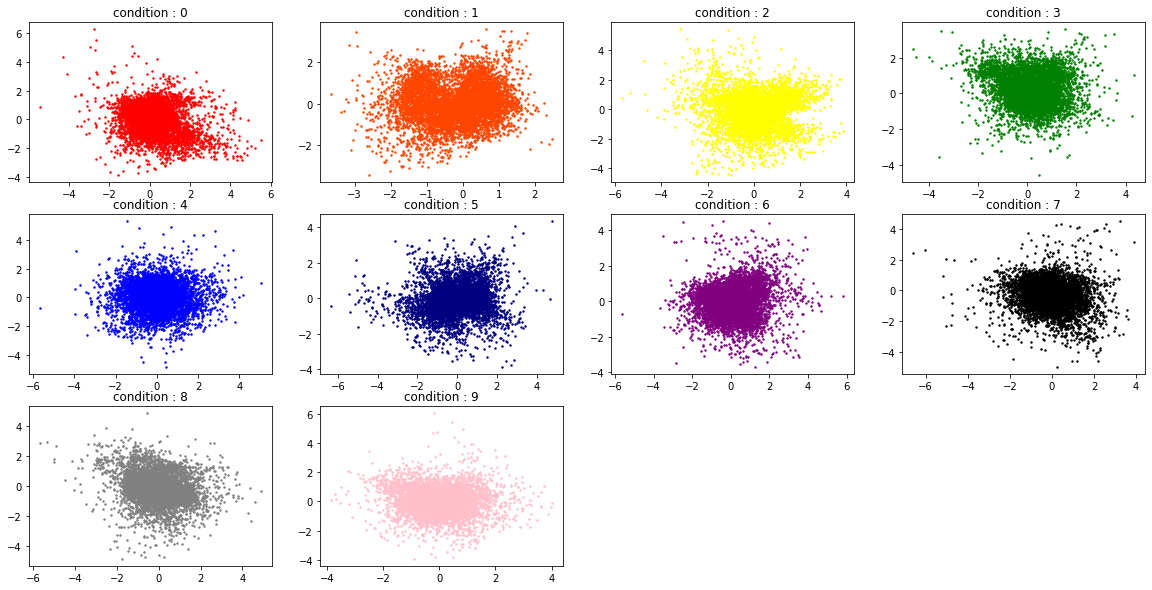

In [ ]:
z_0 = z[train_labels==0]    # z 배열을 조건을 이용해 slice
z_1 = z[train_labels==1]
z_2 = z[train_labels==2]
z_3 = z[train_labels==3]
z_4 = z[train_labels==4]
z_5 = z[train_labels==5]
z_6 = z[train_labels==6]
z_7 = z[train_labels==7]
z_8 = z[train_labels==8]
z_9 = z[train_labels==9]

plt.figure(figsize=(20,10))
plt.tight_layout()

plt.subplot(341)
plt.title('condition : 0')
plt.scatter(z_0[:,0], z_0[:,1], c = 'r', s =2)
plt.subplot(342)
plt.title('condition : 1')
plt.scatter(z_1[:,0], z_1[:,1], c = 'orangered',s =2)
plt.subplot(343)
plt.title('condition : 2')
plt.scatter(z_2[:,0], z_2[:,1], c = 'yellow',s =2)
plt.subplot(344)
plt.title('condition : 3')
plt.scatter(z_3[:,0], z_3[:,1], c = 'green',s =2)
plt.subplot(345)
plt.title('condition : 4')
plt.scatter(z_4[:,0], z_4[:,1], c = 'b',s =2)
plt.subplot(346)
plt.title('condition : 5')
plt.scatter(z_5[:,0], z_5[:,1], c = 'navy',s =2)
plt.subplot(347)
plt.title('condition : 6')
plt.scatter(z_6[:,0], z_6[:,1], c = 'purple',s =2)
plt.subplot(348)
plt.title('condition : 7')
plt.scatter(z_7[:,0], z_7[:,1], c = 'black',s =2)
plt.subplot(349)
plt.title('condition : 8')
plt.scatter(z_8[:,0], z_8[:,1], c = 'gray',s =2)
plt.subplot(3,4,10)
plt.title('condition : 9')
plt.scatter(z_9[:,0], z_9[:,1], c = 'pink',s =2)

plt.show()

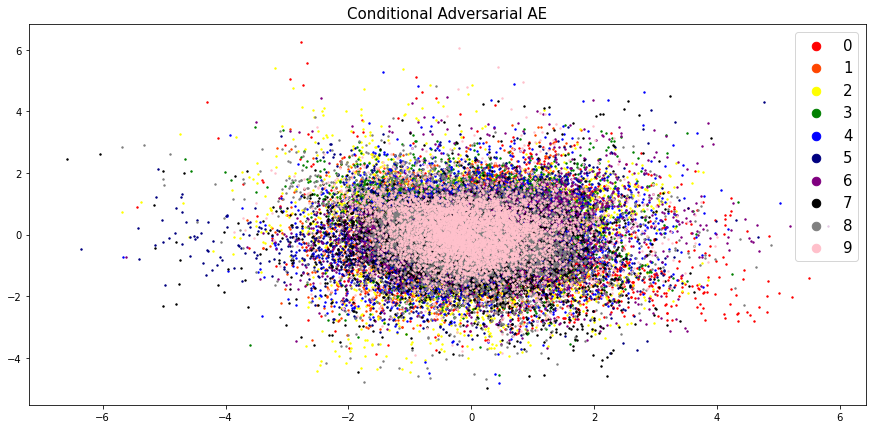

In [ ]:
plt.figure(figsize=(15,7))
plt.title('Conditional Adversarial AE', fontsize = 15)

plt.scatter(z_0[:,0], z_0[:,1], c = 'r', s =2)
plt.scatter(z_1[:,0], z_1[:,1], c = 'orangered',s =2)
plt.scatter(z_2[:,0], z_2[:,1], c = 'yellow',s =2)
plt.scatter(z_3[:,0], z_3[:,1], c = 'green',s =2)
plt.scatter(z_4[:,0], z_4[:,1], c = 'b',s =2)
plt.scatter(z_5[:,0], z_5[:,1], c = 'navy',s =2)
plt.scatter(z_6[:,0], z_6[:,1], c = 'purple',s =2)
plt.scatter(z_7[:,0], z_7[:,1], c = 'black',s =2)
plt.scatter(z_8[:,0], z_8[:,1], c = 'gray',s =2)
plt.scatter(z_9[:,0], z_9[:,1], c = 'pink',s =2)

plt.legend([0,1,2,3,4,5,6,7,8,9], fontsize = 15, markerscale=6)
plt.show()

- condition을 준 z에 대하여 시각화를 해보면 우리의 바람과 동일하게 z가 분포됨을 확인할 수 있다.

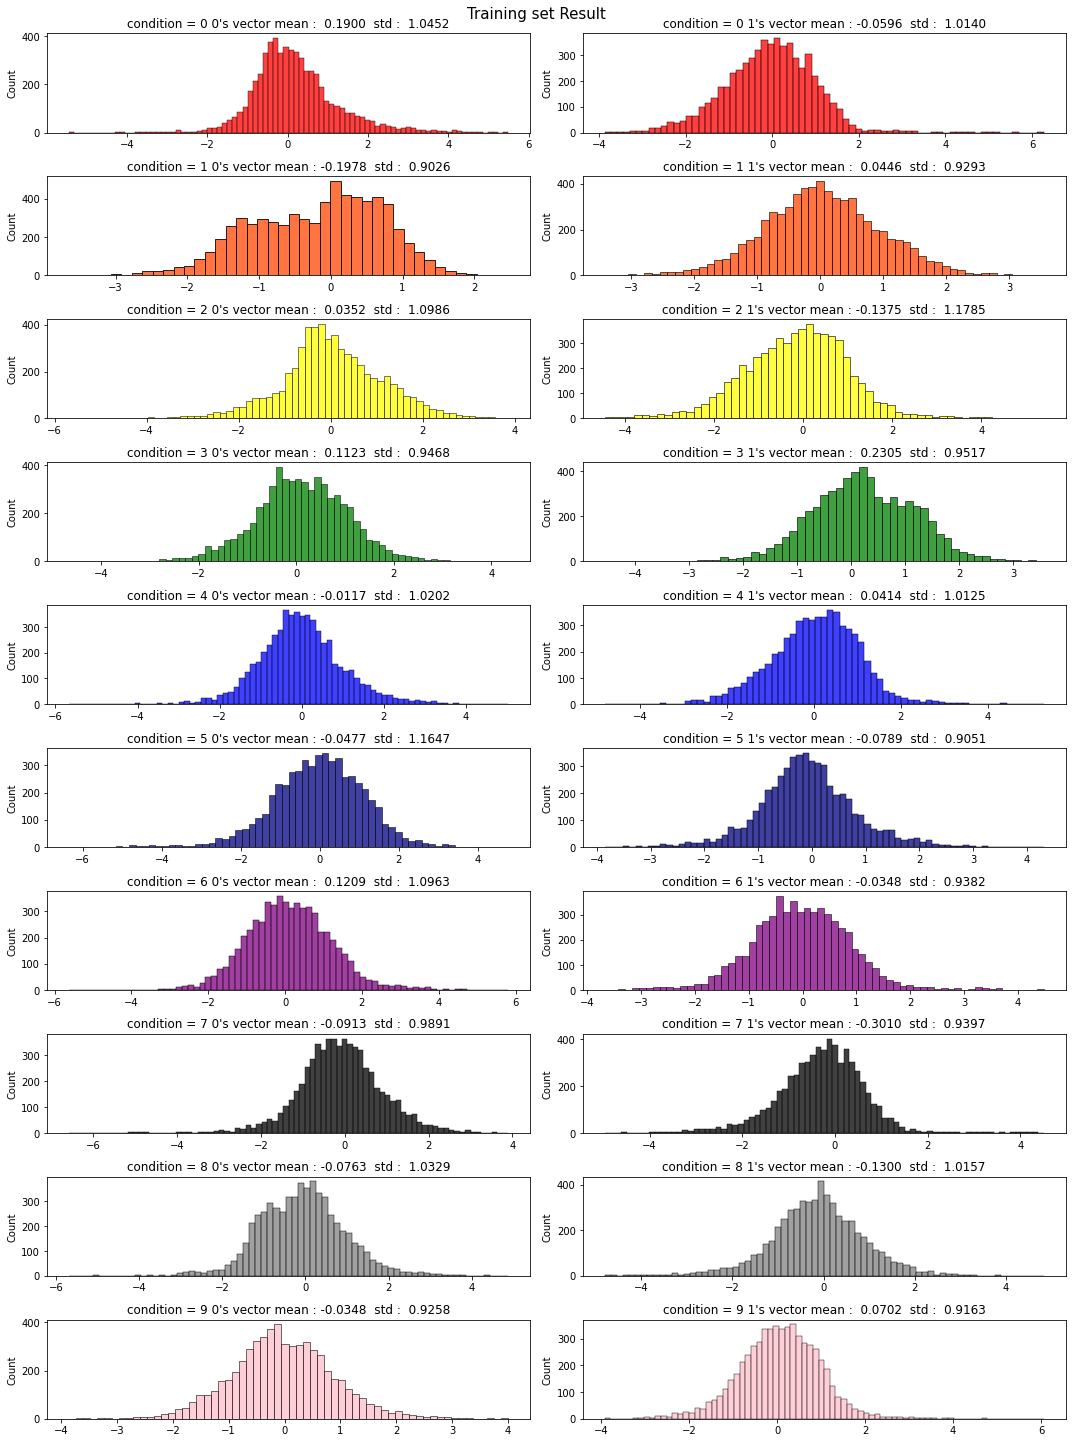

In [ ]:
import seaborn as sns

z_list = [z_0,z_1,z_2,z_3,z_4,z_5,z_6,z_7,z_8,z_9]
color_list = ['r', 'orangered', 'yellow', 'green', 'b', 'navy', 'purple', 'black', 'gray', 'pink']
f, axes = plt.subplots(10,2 , figsize = (15,20))
axes = axes.flatten()

j = 0
for i in range(0,10) :
  mean = np.mean(z_list[i][:,0])
  std = np.std(z_list[i][:,0])
  sns.histplot(z_list[i][:,0] ,ax = axes[j], color= color_list[i])
  axes[j].set_title(f"condition = {i} 0's vector mean : {mean : .4f}  std : {std : .4f}")
  j += 1
  
  mean = np.mean(z_list[i][:,1])
  std = np.std(z_list[i][:,1])
  sns.histplot(z_list[i][:,1] ,ax = axes[j], color = color_list[i])
  axes[j].set_title(f"condition = {i} 1's vector mean : {mean : .4f}  std : {std : .4f}")
  j += 1

plt.suptitle('Training set Result', y = 1, fontsize = 15)
plt.tight_layout()
plt.show()

- 앞의 VAE와 비교 하였을 때, 앞의 VAE Condition = 0, 1 에 대해서는 normal distribution으로 보기 힘들었지만, 이 CAAE는 모든 condition에 대해서 normal distribution으로 볼 수 있다. 

- 즉, prior에서 sampling 된 값들 만으로 원하는 normal distribution을 만들어 냈다.

In [ ]:
z_test = c_vae_encoder([test_images,test_label_onehots])
y_test = c_vae_decoder([z_test, test_label_onehots])

print(z_test.shape)
print(y_test.shape)

(10000, 2)
(10000, 28, 28)


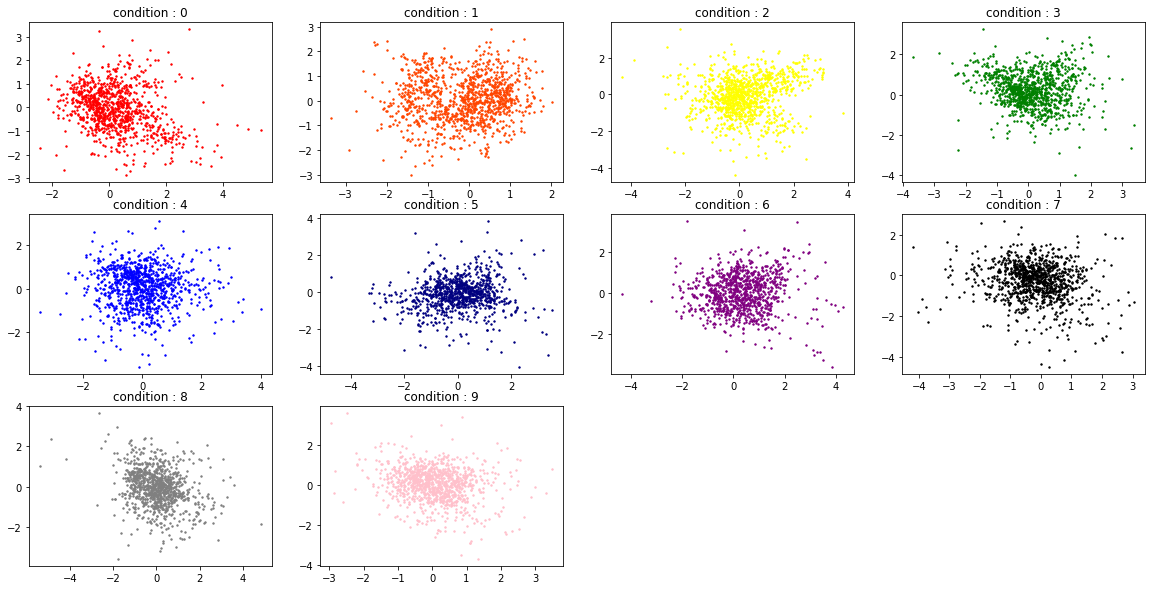

In [ ]:
z_0 = z_test[test_labels==0]    # z 배열을 조건을 이용해 slice
z_1 = z_test[test_labels==1]
z_2 = z_test[test_labels==2]
z_3 = z_test[test_labels==3]
z_4 = z_test[test_labels==4]
z_5 = z_test[test_labels==5]
z_6 = z_test[test_labels==6]
z_7 = z_test[test_labels==7]
z_8 = z_test[test_labels==8]
z_9 = z_test[test_labels==9]

plt.figure(figsize=(20,10))
plt.tight_layout()

plt.subplot(341)
plt.title('condition : 0')
plt.scatter(z_0[:,0], z_0[:,1], c = 'r', s =2)
plt.subplot(342)
plt.title('condition : 1')
plt.scatter(z_1[:,0], z_1[:,1], c = 'orangered',s =2)
plt.subplot(343)
plt.title('condition : 2')
plt.scatter(z_2[:,0], z_2[:,1], c = 'yellow',s =2)
plt.subplot(344)
plt.title('condition : 3')
plt.scatter(z_3[:,0], z_3[:,1], c = 'green',s =2)
plt.subplot(345)
plt.title('condition : 4')
plt.scatter(z_4[:,0], z_4[:,1], c = 'b',s =2)
plt.subplot(346)
plt.title('condition : 5')
plt.scatter(z_5[:,0], z_5[:,1], c = 'navy',s =2)
plt.subplot(347)
plt.title('condition : 6')
plt.scatter(z_6[:,0], z_6[:,1], c = 'purple',s =2)
plt.subplot(348)
plt.title('condition : 7')
plt.scatter(z_7[:,0], z_7[:,1], c = 'black',s =2)
plt.subplot(349)
plt.title('condition : 8')
plt.scatter(z_8[:,0], z_8[:,1], c = 'gray',s =2)
plt.subplot(3,4,10)
plt.title('condition : 9')
plt.scatter(z_9[:,0], z_9[:,1], c = 'pink',s =2)

plt.show()

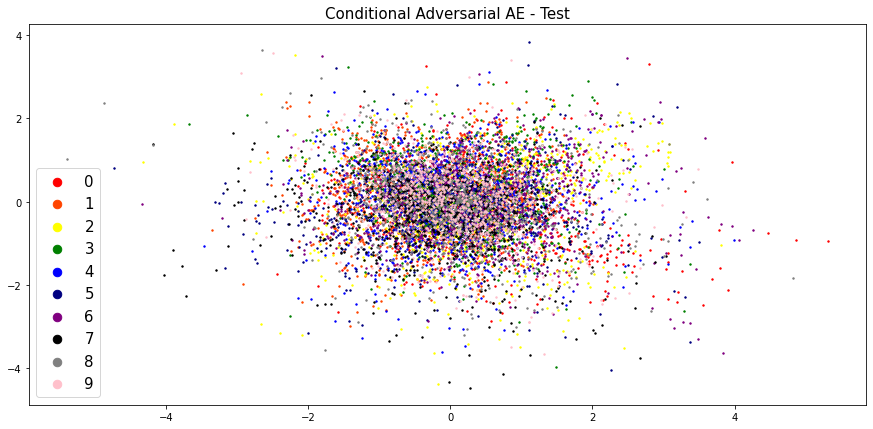

In [ ]:
plt.figure(figsize=(15,7))
plt.title('Conditional Adversarial AE - Test', fontsize = 15)

plt.scatter(z_0[:,0], z_0[:,1], c = 'r', s =2)
plt.scatter(z_1[:,0], z_1[:,1], c = 'orangered',s =2)
plt.scatter(z_2[:,0], z_2[:,1], c = 'yellow',s =2)
plt.scatter(z_3[:,0], z_3[:,1], c = 'green',s =2)
plt.scatter(z_4[:,0], z_4[:,1], c = 'b',s =2)
plt.scatter(z_5[:,0], z_5[:,1], c = 'navy',s =2)
plt.scatter(z_6[:,0], z_6[:,1], c = 'purple',s =2)
plt.scatter(z_7[:,0], z_7[:,1], c = 'black',s =2)
plt.scatter(z_8[:,0], z_8[:,1], c = 'gray',s =2)
plt.scatter(z_9[:,0], z_9[:,1], c = 'pink',s =2)

plt.legend([0,1,2,3,4,5,6,7,8,9], fontsize = 15, markerscale=6)
plt.show()

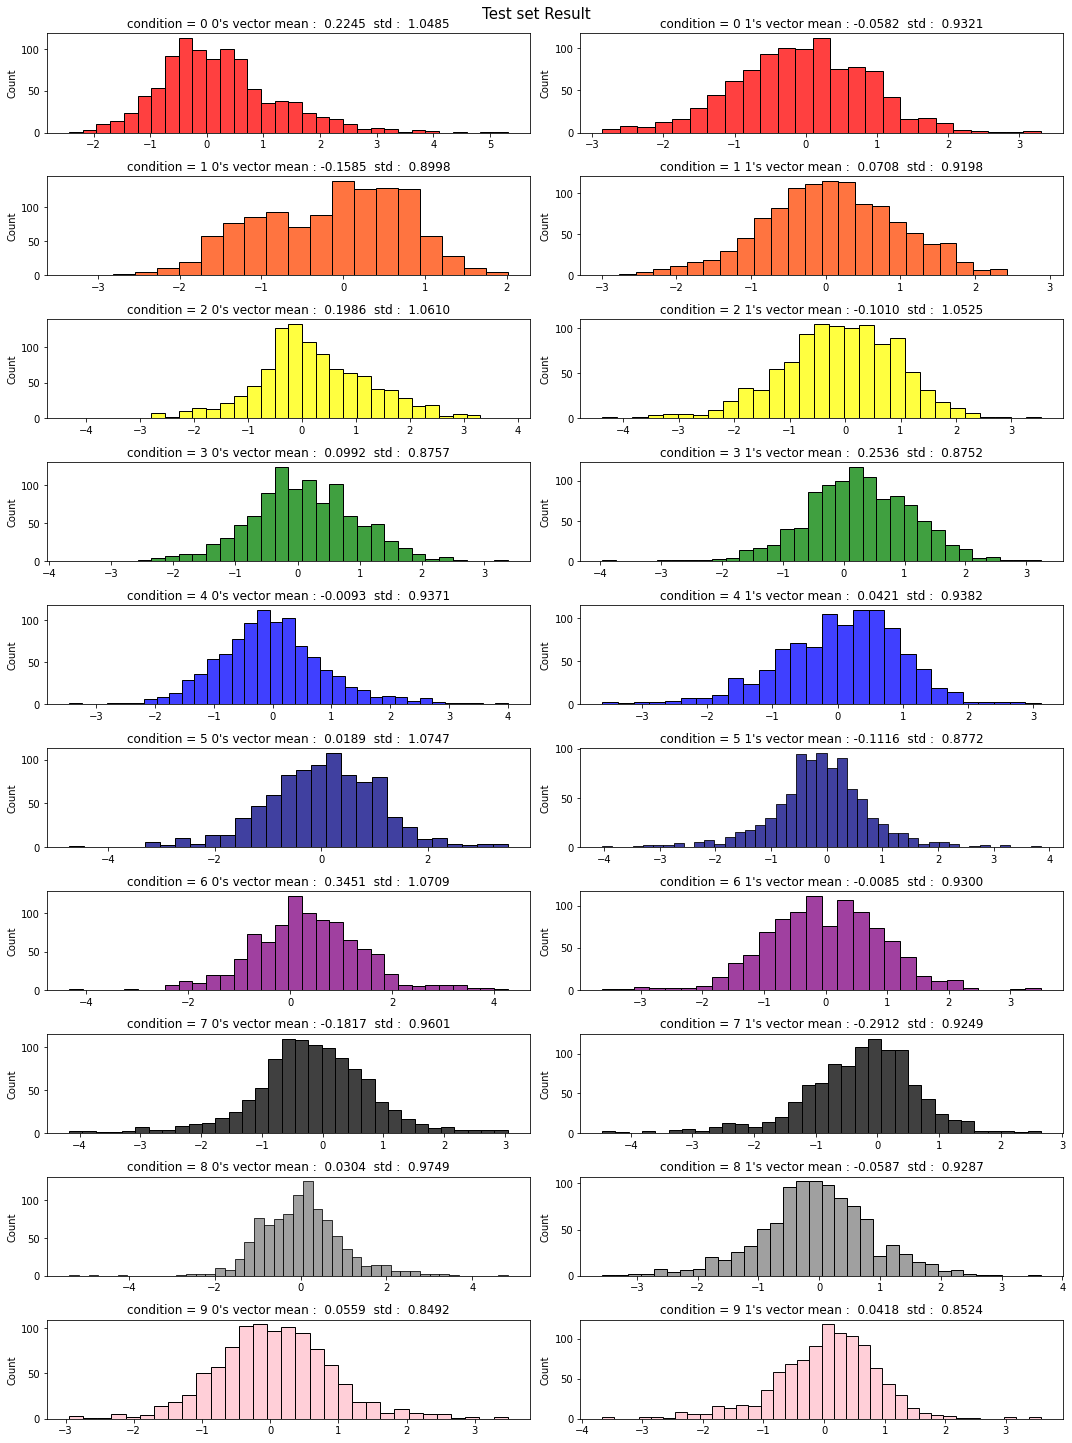

In [ ]:
import seaborn as sns

z_list = [z_0,z_1,z_2,z_3,z_4,z_5,z_6,z_7,z_8,z_9]
color_list = ['r', 'orangered', 'yellow', 'green', 'b', 'navy', 'purple', 'black', 'gray', 'pink']
f, axes = plt.subplots(10,2 , figsize = (15,20))
axes = axes.flatten()

j = 0
for i in range(0,10) :
  mean = np.mean(z_list[i][:,0])
  std = np.std(z_list[i][:,0])
  sns.histplot(z_list[i][:,0] ,ax = axes[j], color= color_list[i])
  axes[j].set_title(f"condition = {i} 0's vector mean : {mean : .4f}  std : {std : .4f}")
  j += 1
  
  mean = np.mean(z_list[i][:,1])
  std = np.std(z_list[i][:,1])
  sns.histplot(z_list[i][:,1] ,ax = axes[j], color = color_list[i])
  axes[j].set_title(f"condition = {i} 1's vector mean : {mean : .4f}  std : {std : .4f}")
  j += 1

plt.suptitle('Test set Result', y = 1, fontsize = 15)
plt.tight_layout()
plt.show()

- test set에 대해서도 앞의 VAE와 비교 하였을 때, 앞의 VAE Condition = 0, 1 에 대해서는 normal distribution으로 보기 힘들었지만, 이 CAAE는 모든 condition에 대해서 normal distribution으로 볼 수 있다.

In [ ]:
z = c_vae_encoder([train_images,train_label_onehots])
y = c_vae_decoder([z, train_label_onehots])

print(z.shape)
print(y.shape)

def z_show(idx):
  print(z[idx])
  print('GT label:', train_labels[idx])

widgets.interact(z_show, idx=widgets.IntSlider(min=0, max=train_images.shape[0]-1));

(60000, 2)
(60000, 28, 28)


interactive(children=(IntSlider(value=0, description='idx', max=59999), Output()), _dom_classes=('widget-inter…

In [ ]:
## 디코더의 테스트 입력 설정

import ipywidgets as widgets

u=widgets.FloatSlider(min=-5.0, max=5.0)
v=widgets.FloatSlider(min=-5.0, max=5.0)

ui = widgets.HBox([u,v])

def z_test(u, v):
  z_test = np.array([[u,v]])  
  c_test = np.array([[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]]) # ground truth : 5 라는 condition을 부여
  print(z_test)

  img_gen = c_vae_decoder([z_test, c_test])
  plt.imshow(img_gen[0])
  plt.show()  

out = widgets.interactive_output(z_test, {'u': u, 'v': v})

display(ui, out)

Output()

- q(z|x)에서 idx = 0에 대하여 뽑힌 z 값 (0.20, -0.56) GT : 5을 decoder의 input으로 넣었을 경우 output을 시각화 해보면, 이미지를 상당히 잘 만들어 내는 것을 확인할 수 있다.

In [ ]:
prior_sample = prior.sample(sample_shape=(10))
prior_sample

<tf.Tensor: shape=(10, 2), dtype=float32, numpy=
array([[-0.5932711 ,  0.23138462],
       [-0.7481574 ,  1.8544167 ],
       [ 1.2741855 , -0.45799074],
       [-0.29497054, -2.1217976 ],
       [ 0.3805146 ,  0.24838348],
       [-1.5417329 ,  1.0886327 ],
       [-1.111891  , -0.04563739],
       [ 1.2103903 , -0.08172323],
       [-0.01329302,  0.48448837],
       [ 0.5697908 , -1.8029608 ]], dtype=float32)>

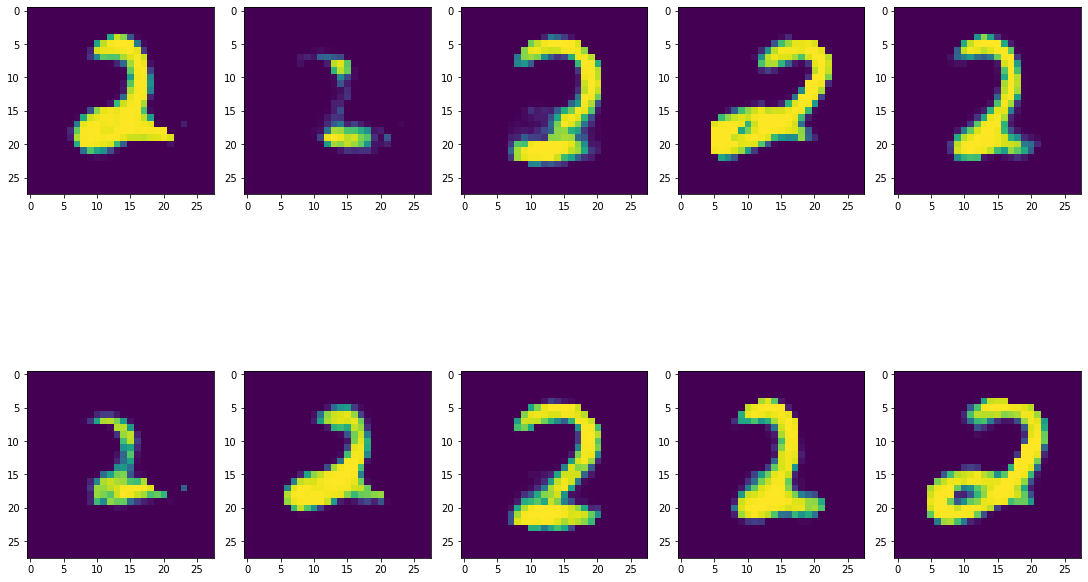

In [ ]:
f, axes = plt.subplots(2,5 , figsize = (15,10), constrained_layout=True)
axes = axes.flatten()

for i in range(len(prior_sample)) :
  z_sample = np.array([prior_sample[i]])
  condition_sample = np.array([[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]) # GT = 2 로 condition 부여 
  img_gen = c_vae_decoder([z_sample, condition_sample])
  axes[i].imshow(img_gen[0])
plt.show()

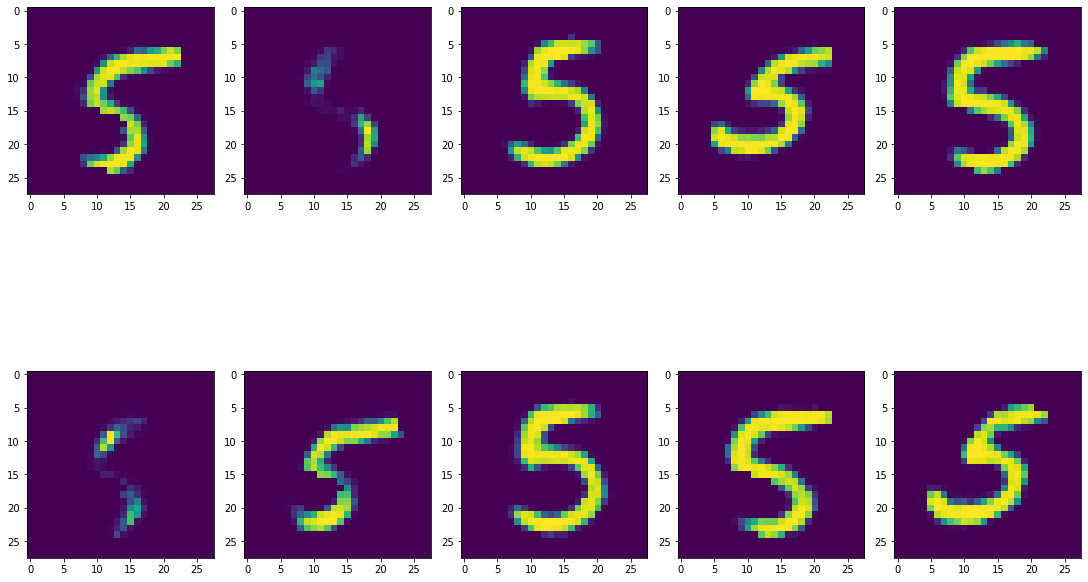

In [ ]:
f, axes = plt.subplots(2,5 , figsize = (15,10), constrained_layout=True)
axes = axes.flatten()

for i in range(len(prior_sample)) :
  z_sample = np.array([prior_sample[i]])
  condition_sample = np.array([[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]]) # GT = 5 로 condition 부여 
  img_gen = c_vae_decoder([z_sample, condition_sample])
  axes[i].imshow(img_gen[0])
plt.show()

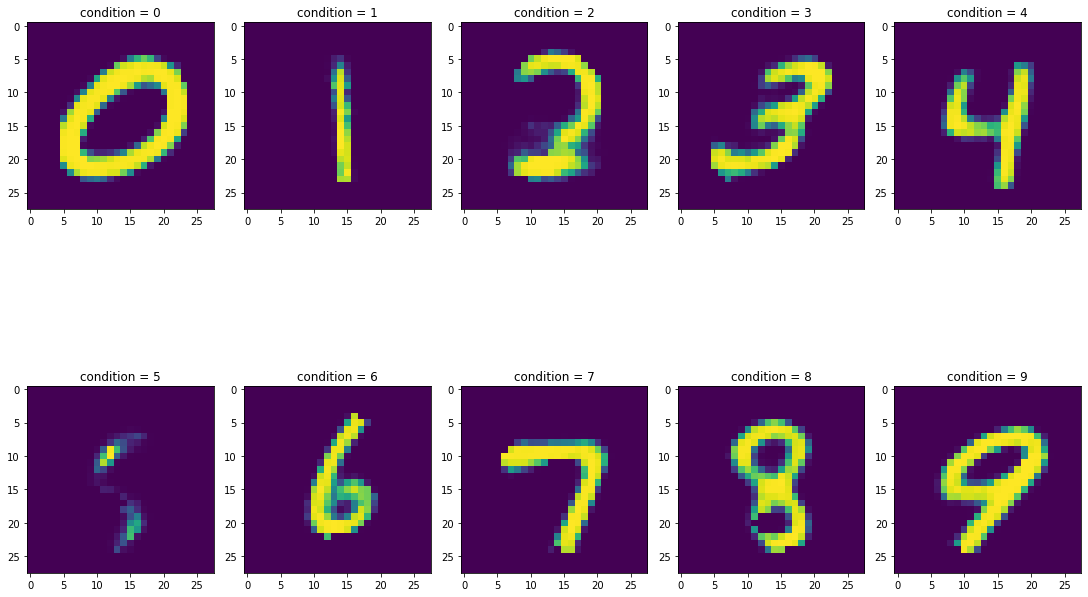

In [ ]:
f, axes = plt.subplots(2,5 , figsize = (15,10), constrained_layout=True)
axes = axes.flatten()

for i in range(len(prior_sample)) :
  z_sample = np.array([prior_sample[i]])
  condition_sample = np.array([[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]])
  condition_sample[0][i] = 1.0
  img_gen = c_vae_decoder([z_sample, condition_sample])
  axes[i].imshow(img_gen[0])
  axes[i].set_title(f"condition = {i}")
plt.show()

- 결과를 확인해 보면 , prior 분포인 p(z)에서 sampling한 z값에 대해서도 condition을 결합하면 이미지 생성을 잘 해냄을 확인할 수 있다.